## Development notebook for `build_predictions()` and `build_heatmap()`


In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys, os, random, pprint
sys.path.append('../')

import tensorflow as tf
import keras.backend as KB

import numpy as np
import skimage.io
import mrcnn.visualize as visualize
import mrcnn.utils as utils
from mrcnn.datagen         import data_generator, load_image_gt, data_gen_simulate
from mrcnn.utils           import mask_string, parse_image_meta, apply_box_deltas_tf
from mrcnn.visualize       import display_instances_with_mask,display_training_batch
from mrcnn.prep_notebook   import mrcnn_coco_test, mrcnn_coco_train, prep_coco_dataset, run_mrcnn_training_pipeline 
# from mrcnn.utils           import log
pp = pprint.PrettyPrinter(indent=2, width=100)
np.set_printoptions(linewidth=100,precision=4,threshold=1000, suppress = True)

mrcnn_model, mrcnn_config = mrcnn_coco_train(mode = 'trainfcn', batch_sz=1)


Using TensorFlow backend.


>>> Initialize Paths
 windows  Windows

Paths:
-------------------------
COCO_DATASET_PATH              F:\MLDatasets\coco2014
COCO_HEATMAP_PATH              F:\MLDatasets\coco2014_heatmaps
COCO_MODEL_PATH                F:\PretrainedModels\mask_rcnn_coco.h5
DIR_DATASET                    F:\MLDatasets
DIR_PRETRAINED                 F:\PretrainedModels
DIR_ROOT                       F:\
DIR_TRAINING                   F:\models
FCN_TRAINING_PATH              F:\models\train_fcn_coco
FCN_VGG16_MODEL_PATH           F:\PretrainedModels\fcn_vgg16_weights_tf_dim_ordering_tf_kernels.h5
MRCNN_TRAINING_PATH            F:\models\train_mrcnn_coco
RESNET_MODEL_PATH              F:\PretrainedModels\resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
VGG16_MODEL_PATH               F:\PretrainedModels\vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5


>>> Initialize ModelBase model 
   Mode      :  trainfcn
   Model dir :  F:\models\train_mrcnn_coco
>>> ModelBase initialiation complete
>>> ---Initi

    alt_scores_2    :  (None, 3)  Keras tensor  False
    alt_scores_2(scattered)       :  (1, 81, 200, 3)  Keras tensor  False

       Normalize_scores() ------------------------------------------------------
         input shape      :  (1, 81, 200, 3)
         reduce_min shape :  (1, 81, 1, 3)
         reduce_max shape :  (1, 81, 1, 3)
             output shape :  (1, 81, 200, 3)

    alt_scores_2_norm(by_class)  :  (1, 81, 200, 3) (1, 81, 200, 3)
    reshaped heatmap   :  (1, 256, 256, 81)  Keras tensor  False
    gauss_scores    :  (1, 81, 200, 23)  Keras tensor  False
    complete

    pred_refined_heatmap        :  (1, 256, 256, 81) Keras tensor  False
    pred_refnined_heatmap_scores:  (1, 81, 200, 23) Keras tensor  False
    complete
--------------------------------
>>>  CHM Layer COMPUTE OUTPUT SHAPE 
--------------------------------
<class 'list'> 3

-----------------------------------------
>>>  CHM Layer (Ground Truth Generation) 
-----------------------------------------


####  Load Model Weights

In [2]:
# exclude=["mrcnn_class_logits"] # ,"mrcnn_bbox_fc"]   #, "mrcnn_bbox", "mrcnn_mask"])
mrcnn_model.load_model_weights(init_with = 'last', exclude = None)  

-----------------------------------------------
 Load Model with init parm: [ last ]
-----------------------------------------------
 ---> last
>>> find_last checkpoint in :  F:\models\train_mrcnn_coco
    Dir starting with  mrcnn  : ['mrcnn20181011T1100', 'mrcnn20181125T1326']
    Folder:  F:\models\train_mrcnn_coco\mrcnn20181125T1326
    Checkpoints:  []
    Folder:  F:\models\train_mrcnn_coco\mrcnn20181011T1100
    Checkpoints:  ['mrcnn_0001.h5', 'mrcnn_0034.h5', 'mrcnn_0071.h5', 'mrcnn_0103.h5']
    find_last():   dir_name: F:\models\train_mrcnn_coco\mrcnn20181011T1100
    find_last(): checkpoint: F:\models\train_mrcnn_coco\mrcnn20181011T1100\mrcnn_0103.h5
>>> load_weights() from : F:\models\train_mrcnn_coco\mrcnn20181011T1100\mrcnn_0103.h5
layers type:  <class 'list'> length:  383
    Weights file loaded: F:\models\train_mrcnn_coco\mrcnn20181011T1100\mrcnn_0103.h5 
MRCNN  MODEL Load weight file COMPLETE 


###  Load dataset

In [3]:
##------------------------------------------------------------------------------------
## Build & Load Training and Validation datasets
## train  : 82081 |  train + val35k : 117266
## val    : 40137 | val35k : 35185 |  minival:  4952
## 
#   'accessory':   [27, 28, 31, 32, 33],
#   'animal':     [16, 17, 18, 19, 20, 21, 22, 23, 24, 25],
#   'appliance':  [78, 79, 80, 81, 82],
#   'background': [0],
#   'electronic': [72, 73, 74, 75, 76, 77],
#   'food':       [52, 53, 54, 55, 56, 57, 58, 59, 60, 61],
#   'furniture':  [62, 63, 64, 65, 67, 70],
#   'indoor':     [84, 85, 86, 87, 88, 89, 90],
#   'kitchen':    [44, 46, 47, 48, 49, 50, 51],
#   'outdoor':    [10, 11, 13, 14, 15],
#   'person':     [1],
#   'sports':     [34, 35, 36, 37, 38, 39, 40, 41, 42, 43],
#   'vehicle':    [2, 3, 4, 5, 6, 7, 8, 9]} 
##------------------------------------------------------------------------------------
# load_class_ids = [62,63,64,65,67,70, 44,46,47,48,49,50,51,  72,73,74,75,76,77 , 82,61]
load_class_ids = [62, 63, 67, 78, 79, 80, 81, 82, 72, 73, 74, 75, 76, 77]

dataset_train, train_generator = prep_coco_dataset(["train", 'val35k'], mrcnn_config, generator = True, shuffle = False, return_coco =True, active_class_ids=load_class_ids)
 

COCO loading annotations file F:\MLDatasets\coco2014\annotations/instances_train2014.json  into memory...
Done (t=17.30s)
creating index...
index created!
 load subset of classes:  [62, 63, 67, 78, 79, 80, 81, 82, 72, 73, 74, 75, 76, 77]
 image dir            :  F:\MLDatasets\coco2014\train2014
 json_path_dir        :  F:\MLDatasets\coco2014\annotations/instances_train2014.json
 number of images     :  24242
 image_ids[:10]       :  [131074, 131075, 524311, 524314, 262172, 393251, 131113, 524340, 393268, 262207]
 image_ids[1000:1010] :  [5113, 5115, 267266, 136200, 398349, 529427, 5140, 5142, 136230, 136232]
COCO loading annotations file F:\MLDatasets\coco2014\annotations/instances_valminusminival2014.json  into memory...
Done (t=7.31s)
creating index...
index created!
 load subset of classes:  [62, 63, 67, 78, 79, 80, 81, 82, 72, 73, 74, 75, 76, 77]
 image dir            :  F:\MLDatasets\coco2014\val2014
 json_path_dir        :  F:\MLDatasets\coco2014\annotations/instances_valminusmin

#### List trainable layers using `get_trainable_layers()` 

In [ ]:
for i in  mrcnn_model.get_trainable_layers():
    print(' Layer:', i.name)    

## Display Images

In [4]:
print(dataset_train.active_class_ids)
# pp.pprint(dataset_train.category_to_class_map)
print()
pp.pprint(dataset_train.category_to_external_class_map)
print(' dataset_train.source_objs:   ',dataset_train.source_objs)
print(' len of dataset_train.image_info: ', len(dataset_train.image_info))
print(dataset_train.image_info[0].keys())
for i in range(10):
    p = dataset_train.image_info[i]
    print(i,p['id'], p['source'], p['path'])

[62, 63, 67, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82]

{ 'accessory': [27, 28, 31, 32, 33],
  'animal': [16, 17, 18, 19, 20, 21, 22, 23, 24, 25],
  'appliance': [78, 79, 80, 81, 82],
  'background': [0],
  'electronic': [72, 73, 74, 75, 76, 77],
  'food': [52, 53, 54, 55, 56, 57, 58, 59, 60, 61],
  'furniture': [62, 63, 64, 65, 67, 70],
  'indoor': [84, 85, 86, 87, 88, 89, 90],
  'kitchen': [44, 46, 47, 48, 49, 50, 51],
  'outdoor': [10, 11, 13, 14, 15],
  'person': [1],
  'sports': [34, 35, 36, 37, 38, 39, 40, 41, 42, 43],
  'vehicle': [2, 3, 4, 5, 6, 7, 8, 9]}
 dataset_train.source_objs:    {'train': <pycocotools.coco.COCO object at 0x000000A3CBE59DA0>, 'val35k': <pycocotools.coco.COCO object at 0x000000A3DEB1B898>}
 len of dataset_train.image_info:  34562
dict_keys(['width', 'path', 'id', 'annotations', 'source', 'height'])
0 131074 coco F:\MLDatasets\coco2014\train2014\COCO_train2014_000000131074.jpg
1 131075 coco F:\MLDatasets\coco2014\train2014\COCO_train2014_000000131075.jpg


###  Display image with Ground Truth bounding boxes and masks

D:\Program Files\Anaconda3\envs\TF\lib\site-packages\scipy\ndimage\interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


 Image_id    :  0  Reference:  http://cocodataset.org/#explore?id=131074 Coco Id: 131074
 Image meta [   0  428  640    3  169    0  854 1024    1    1]
 Class ids   :  (5,)    [60 60 27 66 60]
 Class Names :  ['bed', 'bed', 'handbag', 'remote', 'bed']


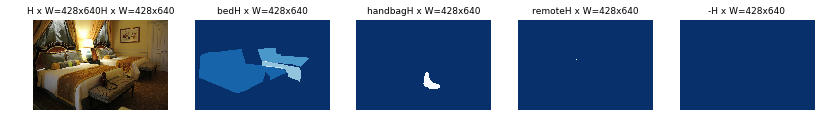

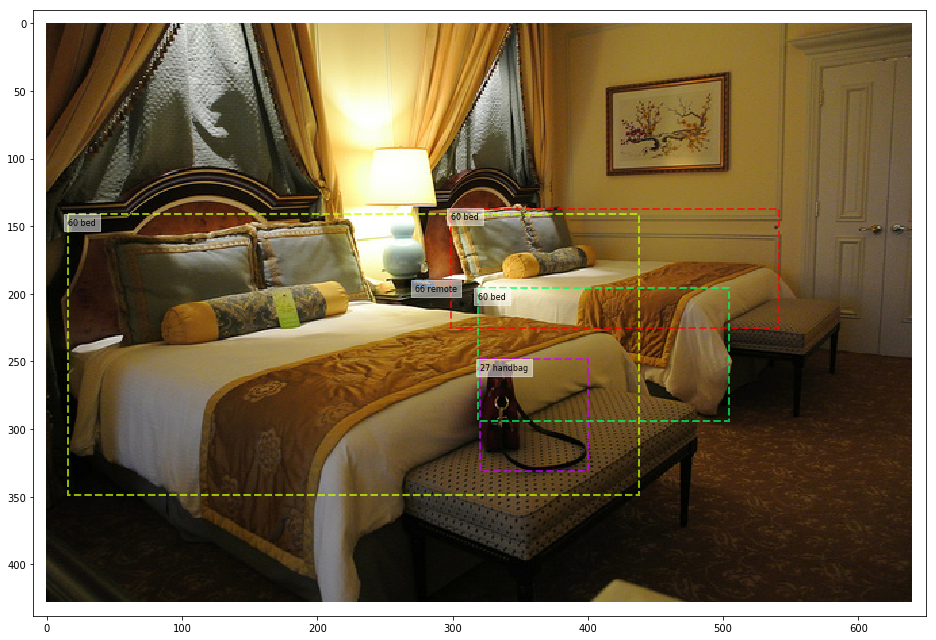

In [5]:
train_batch_x, train_batch_y = next(train_generator)
display_training_batch(dataset_train, train_batch_x)

In [6]:
IMAGE_LIST = train_batch_x[1][:,0]
print('IMAGE_LIST : ', IMAGE_LIST)
for image_id in IMAGE_LIST:
    print()
    print('IMAGE_ID : ', image_id)#### Load a specific image using image_id
    annotations = dataset_train.image_info[image_id]["annotations"]
#     print(annotations)
    for annotation in annotations:
        class_id = dataset_train.map_source_class_id( "coco.{}".format(annotation['category_id']))
        print("coco.id: {} --> class_id : {}  - {} ".format(annotation['category_id'],class_id, dataset_train.class_names[class_id]))

IMAGE_LIST :  [0]

IMAGE_ID :  0
coco.id: 65 --> class_id : 60  - bed 
coco.id: 65 --> class_id : 60  - bed 
coco.id: 31 --> class_id : 27  - handbag 
coco.id: 75 --> class_id : 66  - remote 
coco.id: 65 --> class_id : 60  - bed 


### Load a specific image using image_id

In [ ]:
train_batch_x, _ =  data_gen_simulate(dataset_train, mrcnn_model.config, [0])
visualize.display_training_batch(dataset_train, train_batch_x)
# for i in train_batch_x_1:
#     print(i.shape)
# print(mrcnn_model.keras_model.input_names)
# imgmeta_idx = mrcnn_model.keras_model.input_names.index('input_image_meta')
# print(imgmeta_idx)
# img_meta    = train_batch_x_1[imgmeta_idx]
# print(img_meta)

# del train_batch_x_1    
IMAGE_LIST = train_batch_x[1][:,0]
print('IMAGE_LIST : ', IMAGE_LIST)
for image_id in IMAGE_LIST:
    print()
    print('IMAGE_ID : ', image_id)#### Load a specific image using image_id
    annotations = dataset_train.image_info[image_id]["annotations"]
#     print(annotations)
    for annotation in annotations:
        class_id = dataset_train.map_source_class_id( "coco.{}".format(annotation['category_id']))
        print("coco.id: {} --> class_id : {}  - {} ".format(annotation['category_id'],class_id, dataset_train.class_names[class_id]))

### other image displays

####  Display Training / Validation Training set information

In [ ]:
print("Train Dataset Image Count: {}".format(len(dataset_train.image_ids)))
print("Training Dataset Class Count: {}".format(dataset_train.num_classes))
for i, info in enumerate(dataset_train.class_info):
    print("{:3}. {:50}".format(i, info['name']))
    
    
print("Validation Dataset Image Count: {}".format(len(dataset_val.image_ids)))
print("Validation Dataset Class Count: {}".format(dataset_val.num_classes))
for i, info in enumerate(dataset_val.class_info):
    print("{:3}. {:50}".format(i, info['name']))    

#### Display top masks for a random group of images

In [ ]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 7)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

#### Display a random image with instances and mask

In [ ]:
# Load random image and mask.
# image_id = np.random.choice(dataset_train.image_ids)


image    = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset_train.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
print(class_ids.shape[0], bbox.shape[0])
# Display image and instances
visualize.display_instances_with_mask(image, bbox, mask, class_ids, dataset_train.class_names)

## Run data through model

####  `run_mrcnn_training_pipeline()`

In [7]:
outputs = run_mrcnn_training_pipeline(mrcnn_model, dataset_train, train_batch_x, verbose= 1)

** Pass through MRCNN model:
/* Inputs */
Input  0:  (input_image:0                           ) 	  Input shape: (1, 1024, 1024, 3)
Input  1:  (input_image_meta:0                      ) 	  Input shape: (1, 89)
Input  2:  (input_rpn_match:0                       ) 	  Input shape: (1, 261888, 1)
Input  3:  (input_rpn_bbox:0                        ) 	  Input shape: (1, 256, 4)
Input  4:  (input_gt_class_ids:0                    ) 	  Input shape: (1, 100)
Input  5:  (input_gt_boxes:0                        ) 	  Input shape: (1, 100, 4)

Requested layers:
-----------------
Layer   0:  (cntxt_layer/pred_heatmap:0              ) 	  Input shape: (1, 256, 256, 81)
Layer   1:  (cntxt_layer/pred_heatmap_scores:0       ) 	  Input shape: (1, 81, 200, 23)
Layer   2:  (cntxt_layer_gt/gt_heatmap:0             ) 	  Input shape: (1, 256, 256, 81)
Layer   3:  (cntxt_layer_gt/gt_heatmap_scores:0      ) 	  Input shape: (1, 81, 200, 23)
Layer   4:  (mrcnn_class/Reshape_1:0                 ) 	  Input shape: (

#### Load output data

In [8]:
print(len(outputs), outputs.keys())
model_pr_heatmap                = outputs['mrcnn_output'][0]          # layer:  0   shape: (1, 256, 256, 81)
model_pr_heatmap_scores         = outputs['mrcnn_output'][1]          # layer:  1   shape: (1, 81, 200, 11)
model_gt_heatmap                = outputs['mrcnn_output'][2]          # layer:  2   shape: (1, 256, 256, 81)
model_gt_heatmap_scores         = outputs['mrcnn_output'][3]          # layer:  3   shape: (1, 81, 200, 11)
model_mrcnn_class               = outputs['mrcnn_output'][4]
model_mrcnn_bbox                = outputs['mrcnn_output'][5]
model_output_rois               = outputs['mrcnn_output'][6]
model_target_class_ids          = outputs['mrcnn_output'][7]
model_roi_gt_boxes              = outputs['mrcnn_output'][8]
# model_mrcnn_class_logits        = outputs['mrcnn_output'][9]
# model_active_class_ids          = outputs['mrcnn_output'][10]          # layer:  6   shape: (1, 81)


3 dict_keys(['image_batch', 'mrcnn_input', 'mrcnn_output'])


#### Display output shapes

In [ ]:
print(outputs['image_batch'].shape)
for i in outputs:
    print('Group:', i)
    for item in outputs[i]:
        print(' Type ', type(item), item.shape)

#### Load input data

In [ ]:
input_image          =  train_batch_x[0]
input_image_meta     =  train_batch_x[1]
# input_rpn_match      =  train_batch_x[2]
# input_rpn_bbox       =  train_batch_x[3]
input_gt_class_ids   =  train_batch_x[4]
input_gt_bboxes      =  train_batch_x[5]
print(' Input image shape is    :', input_image.shape)
print(' Input image_meta        :', type(input_image_meta), input_image_meta.shape)
print(' input_image_meta        :', input_image_meta[0,:10])
# print(' input_rpn_match         :', input_rpn_match.shape)
# print(' input_rpn_bbox          :', input_rpn_bbox.shape)
print(' input_gt_class_ids      :', input_gt_class_ids.shape)
print(' input_gt_bboxes         :', input_gt_bboxes.shape)
# h, w = input_image.shape[1], input_image.shape[2]      #  tf.shape(input_image)[1], tf.shape(input_image)[2]
# input_gt_bboxes_norm = tf.identity(input_gt_bboxes / [h,w,h,w])
# print(' input_gt_bboxes_norm    :', input_gt_bboxes_norm.shape)

## Display output from model

####  `input_gt_class_ids`, `input_gt_bboxes`

In [ ]:
# print(roi_gt_boxes[0,:50] * [1024,1024,1024,1024])
print(input_gt_class_ids[0])
print(input_gt_bboxes[0,:10])
# for i in range(input_gt_class_ids.shape[1]):
#     if input_gt_class_ids[0,i] == 1:
#         print(input_gt_class_ids[0,i], '   ', input_gt_bboxes[0,i])

####  Display `output_rois`

In [ ]:
np.set_printoptions(precision=4, threshold=4000, linewidth=210, suppress=True)
img = 0
print(' output_rois')
print(model_output_rois.shape)
# print(output_rois[0,:40,:])
print(model_output_rois [0,:40,:]* [1024, 1024, 1024, 1024])

####  `max_mrcnn_class` , `argmax_mrcnn_class`

In [ ]:
np.set_printoptions(precision=4, threshold=4000, linewidth=210, suppress=True)
print(' mrcnn_class', model_mrcnn_class.shape)
print( model_mrcnn_class[0,:10,:20])
# 
max_mrcnn_class    = np.max(model_mrcnn_class, axis = (0,2))
argmax_mrcnn_class = np.argmax(model_mrcnn_class, axis = 2)

# print()
print('\n mrcnn_class Max Values   : ', max_mrcnn_class.shape)
print(max_mrcnn_class)

# print()
print(' mrcnn_class Argmax Values: ', argmax_mrcnn_class.shape)
print(argmax_mrcnn_class[0])

print(' target_class_ds    Values: ', model_target_class_ids.shape)
print(model_target_class_ids[0])

# for i in range(100):
#     print('Predicted: ', argmax_mrcnn_class[0,i],  '  Actual ', target_class_ids[0,i])
 

In [ ]:
print(' mrcnn_bbox')
print(model_mrcnn_bbox.shape)
print(model_mrcnn_bbox[0,0,:70])

#### Display  `target_class_ids()`, `target_bbox_deltas`, `roi_gt_boxes`

In [ ]:
print(' target_class_ids')
print(model_target_class_ids.shape)
print(model_target_class_ids[0])
# print(model_target_bbox_deltas.shape)
# print(model_target_bbox_deltas[0])
print(model_roi_gt_boxes.shape)
print(model_roi_gt_boxes[0])

####  apply `deltas` from predicted delta `mrcnn_bbox`  to  `output_rois` to obtain refined rois 

In [ ]:
np.set_printoptions(precision=4, threshold=4000, linewidth=210, suppress=True)
img_idx = 0 
classes, deltas = utils.get_predicted_mrcnn_deltas(model_mrcnn_class, model_mrcnn_bbox, verbose=True)
print('output_rois',model_output_rois.shape, 'deltas ', deltas.shape)
cls = 48

for i in range(input_gt_class_ids.shape[1]):
    if input_gt_class_ids[0,i] == cls:
        print(input_gt_class_ids[0,i], '   ', input_gt_bboxes[0,i])

        
print()        
for i in range(model_output_rois.shape[1]):
    if classes[0,i] ==cls:
        print(' i ', i, 'class: ',classes[0,i])
#         print('   orig           : ', output_rois[0,i])
        d1 = deltas[0,i] * mrcnn_config.BBOX_STD_DEV
#         print('   delta          : ', deltas[0,i],'   delta * std dev: ', d1)
        d2 = utils.apply_box_delta(model_output_rois[0,i],d1)
#         print('   refined        : ', d2)
#         print()
        print('   orig           : ', model_output_rois[0,i] * [1024,1024,1024,1024])
        print('   refined        : ', d2 * [1024,1024,1024,1024]) 
        print('   roi_gt_bboxes  : ', model_roi_gt_boxes[0,i]* [1024,1024,1024,1024]) 
        print()
        print('   pred delta     : ', deltas[0,i] )
        print('   tgt delta      : ', model_target_bbox_deltas[0,i] )
        
        print()


####  Display roi_gt_boxes , and class_ids vs. output_bbox and prediceted class_ids

In [ ]:
print(ref_out_roi)

In [ ]:
ref_out_roi1 = ref_out_roi * [1024,1024,1024,1024]
print(ref_out_roi1)
window = np.array([0,0,1024,1024], dtype =float)
print(window.shape)
ref_out_roi2  = utils.clip_to_window_np( window, ref_out_roi1)
print(ref_out_roi2.shape)
for i in range(200):
    print(ref_out_roi1[i],' --- ', ref_out_roi2[i])

#### Display pred_refined_tensor and gt_tensor

In [ ]:
for cls in [1]:
    for box in range(20):
        print(pred_tensor[0,cls,box])
        print(gt_tensor[0,cls,box])
        print()

####  Display roi_gt_boxes along with corresponding refined/clipped output_rois

In [ ]:
img_id = 0
print(roi_gt_boxes[0].shape, target_class_ids[0].shape , np.expand_dims(target_class_ids[0],axis=-1).shape)
classes, deltas = utils.get_predicted_mrcnn_deltas(mrcnn_class, mrcnn_bbox, verbose=True)
deltas *= mrcnn_config.BBOX_STD_DEV
print('classes.shape: ',classes.shape, ' deltas.shape: ',deltas.shape)

ref_out_roi = utils.apply_box_deltas_np(output_rois[img_id],deltas[img_id])
#     ##   Clip boxes to image window    
# print(ref_out_roi.shape)
window = np.array([0,0,1024,1024], dtype =float)
clipped_out_roi  = utils.clip_to_window_np( window, ref_out_roi*[1024,1024,1024,1024])

for i in range(200):
#     ref_out_roi = utils.apply_box_delta_np(output_rois[0],d1[0])
#     if classes[img_id,i] == 1 or target_class_ids[img_id,i] == 1 :

    print('idx: ',200-i,' GT Cls: ', target_class_ids[img_id,i]  , ' -', roi_gt_boxes[img_id,i]*[1024,1024,1024,1024], 
                    ' PR Cls: ', classes[img_id,i],' - ', ref_out_roi[i]*[1024.0,1024.0,1024.0,1024.0] ,
                     'ClpdCls: ', clipped_out_roi[i]   ) #) *[1024,1024,1024,1024]

#### display gt_heatmap_scores and pred_heatmap_scores outputs

In [ ]:
np.set_printoptions(precision=4, threshold=None, linewidth=200, suppress=True)
# print(' gt_tensor')
# print(gt_tensor.shape)
# print(gt_tensor[img,:,:10])
img_id = 1
print(' GT Heatmap Scores')

print('gt_heatmap_scores: ', model_gt_heatmap_scores.dtype,  model_gt_heatmap_scores.shape)
print('pred_heatmap_scores: ', model_pred_heatmap_scores.dtype,  model_pred_heatmap_scores.shape)

# print(gt_heatmap_scores[img,1])
# for img_id in range(mrcnn_config.BATCH_SIZE):

for img_id in [0]:    # print(pred_refined_heatmap_scores[img_id,:4])
    pr_class_ids = np.unique(model_pred_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
    gt_class_ids = np.unique(model_gt_heatmap_scores[img_id,:,:,4]).astype(int).tolist() 
    union_class_ids = np.union1d(pr_class_ids, gt_class_ids)
    print('-'*56)
    print('Image : {}  GT ClassIds: {}   PR ClassIds: {} '.format(img_id, gt_class_ids, pr_class_ids))
    print('Image : {}  Union ClassIds: {}'.format(img_id, union_class_ids))
    print('-'*56)
    for cls in union_class_ids:  
        print()
        for i in range(25):
#             print(' GT: img_id:',img_id, ' cls: ',cls, ' -',gt_tensor[img_id, cls,i]) #, gt_heatmap_scores[img_id, cls,i,7] )
#             print(' PR: img_id:',img_id, ' cls: ',cls, ' -',pred_tensor[img_id,cls,i]) #,pred_refined_heatmap_scores[img_id,cls,i,7])

            print(' GT: img_id:',img_id, ' cls: ',cls, ' -',model_gt_heatmap_scores[img_id, cls,i]) #, gt_heatmap_scores[img_id, cls,i,7] )
            print(' PR: img_id:',img_id, ' cls: ',cls, ' -',model_pred_heatmap_scores[img_id,cls,i]) #,pred_refined_heatmap_scores[img_id,cls,i,7])
            print()

####  Display `Pred_Tensor`, `Pred_heatmap`, `mrcnn_class`

In [ ]:
# np.set_printoptions(precision=4, threshold=None, linewidth=150, suppress=True)
np.set_printoptions(precision=4, threshold=4000, linewidth=210, suppress=True)
img = 0

# max_score = np.max(mrcnn_class, axis = -1)
# max_class = np.argmax(mrcnn_class, axis = -1)
# # print(' output_rois[',img,'] \n', output_rois[1]*[128,128,128,128])
# print('max class shape:',max_class.shape, 'max score shape: ',max_score.shape)
# print('max class[',img,']\n',max_class[img])
# print('max score[',img,']\n',max_score[img])
# print('mrcnn class.shape ',mrcnn_class.shape)
# print('mrcnn_class[',img,',:]\n',mrcnn_class[img,:])
# print(output_rois[1])

print('input_gt_class_ids')
print(input_gt_class_ids[0])

# print(' rpn_bbox')
# print(rpn_bbox.shape)
# print(rpn_bbox[0,:100,:])

# print(' rpn_roi_proposals')
# print(rpn_roi_proposals.shape)
# print(rpn_roi_proposals[0,:100,:])

print(' output_rois')
print(output_rois.shape)
# print(output_rois[0,:40,:])
print(output_rois [0,:40,:]* [1024, 1024, 1024, 1024])

print(' target_class_ids')
print(target_class_ids.shape)
print(target_class_ids[0,:40])
# print(output_rois [0,:40,:]* [1024, 1024, 1024, 1024])

# print(' Pred_tensor')
# print(pred_tensor.shape)
# print(pred_tensor[img,:,:10])

# print(' gt_tensor')
# print(gt_tensor.shape)
# print(gt_tensor[img,:,:10])

# print(' mrcnn_class')
# print( mrcnn_class.shape)
# print( mrcnn_class[0,:,:])

# print(' mrcnn_bbox')
# print( mrcnn_bbox.shape)
# print( mrcnn_bbox)

# print(' roi_gt_boxes')
# print(roi_gt_boxes.shape)
# print(roi_gt_boxes[img,:,:])

# print(' Pred Heatmap Scores')
# print(pred_heatmap_scores.dtype, pred_heatmap_scores.shape)
# print(pred_heatmap_scores[img,1])

# print(' FCN Scores')
# print(fcn_scores.dtype)
# for cls in range(4):
#     print(pred_heatmap_scores[img,cls,:10])
#     print(fcn_scores[img,cls,:10,2:])

  

####  Display `output_rois` for visual check - passed on to  `build_pred_tensor()`

In [ ]:
np.set_printoptions(linewidth=150, precision=6)
# print('scatter shape is ', pred_scatt.get_shape())
print('output_rois shape is ', output_rois.shape)
img = 0
for img in [0]:
    print('Image ', img , ' ------------')
    print(output_rois[img])

####  Display  - `pred_refined_tensor` which is passed on to  `build_heatmap()`

In [ ]:
np.set_printoptions(linewidth=150, precision=6)
img_id = 0
# print('scatter shape is ', pred_scatt.get_shape())
print('model_pred_tensor shape is ', model_pred_tensor.shape)
print(input_image_meta[0,:10])
pr_class_ids = np.unique(model_pred_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
print('Image : {}  PR ClassIds: {} '.format(img_id, pr_class_ids))
for k in pr_class_ids:
    print('Image ', img , '/ Class ',k,' ------------')
    print(model_pred_tensor[img,k,:30])
    

####  Compare  `pred_heatmap_scores` vs. `pred_refined_heatmap_scores`

In [ ]:
np.set_printoptions(precision=4, threshold=4000, linewidth=210, suppress=True)
print('pred_refined_heatmap_scores',pred_refined_heatmap_scores.shape)
cls = 1
for i in range(input_gt_class_ids.shape[1]):
    if input_gt_class_ids[0,i] == cls:
        print(input_gt_class_ids[0,i], '   ', input_gt_bboxes[0,i])
print()        
for i in range(pred_heatmap_scores.shape[2]):
#     print(' ref_ten   : ', pred_refined_tensor[0,1,i])
    print(' hm_scr    : ', pred_heatmap_scores[0,1,i])
    print(' ref_hm_scr: ', pred_refined_heatmap_scores[0,1,i])
    print()    

##  `build_pr_tensor()` , `build_gt_tensor()`

- pick the class with highest probability from mrcnn_class, and it's corresponding bounding box delta
- apply the deltas to the output_rois (output_roi)
- build tensor separating bounding boxes by class_id
- normalize scores per class
- sort based on sequence number 
 

### Some tests on the results

####  Display `pred_tensor`  from model code and code above, `pred_heatmap_scores`  

In [ ]:
np_format = {}
float_formatter = lambda x: "%10.4f" % x
np_format['float']=float_formatter
# np.set_printoptions(linewidth=150, precision=3, floatmode='fixed', threshold =10000, formatter = np_format)  
np.set_printoptions(linewidth=190, precision=4, threshold=10000, suppress = True)
print(pred_tensor)
# print('scatter shape is ', pred_scatt.get_shape())
sess = KB.get_session()
# print('pred tensor from model : ', model_pred_tensor.shape)
with sess.as_default():
#     print('pred_tensor            : ', pred_tensor.get_shape() )
    r_pred_tensor = pred_tensor.eval()
    
    
for img in range(2):
    class_ids = np.unique(r_pred_tensor[img,:,:,4]).astype(int).tolist()    
    print('Classids: ', class_ids)
    for i in class_ids:
        print('Image ', img , '/ Class ',i,' ------------')
        for j in range(25):
            print(r_pred_tensor[img,i,j])
#             print(model_pred_tensor[img,i,j])
#             print(model_pred_heatmap_scores[img,i,j])
#             print(pred_heatmap_scores[img,i,j])
            print()


In [ ]:
np.set_printoptions(precision=4, threshold=4000, linewidth=210, suppress=True)
with sess.as_default():
    print(scatter_ind.shape)
    print(pred_scatt.shape)
    print(pred_array.shape)
#     r_clipped_rois = clipped_rois.eval()
    r_pred_array = pred_array.eval()
for i in range(200):
#     print()
#     print('input_ro:  ', r0[0,i]) 
#     print('original (clipped) :  ', r_clipped_rois[0,i])
    print('pred_array         :  ', r_pred_array[0,i])

In [ ]:
np.set_printoptions(precision=4, threshold=4000, linewidth=210, suppress=True)

# with sess.as_default():
#     print(pred_scores.eval())
#     print(pred_classes.eval())
#     print(scatter_ind.eval()[0])
#     print(norm_score.eval()[0,9])
#     print(pred_array.eval()[0,:200])
#     print(scatter_ind.shape)
#     print(pred_scatt.shape)
#     print(pred_array.shape)
#     r_clipped_rois = clipped_rois.eval()
#     r_pred_array   = pred_array.eval()
#     print(pred_scatt.eval()[0,1,0:200])
#     print(normalizer.eval()[0,9])


####  Test that refined_rois is correctly working in `clip_to_window_tf` 

In [ ]:
with sess.as_default():
    test_np = refined_rois.eval()
    test_tf = refined_rois_clipped.eval()
    window_np = np.array([0,0,128,128])
 
    print(window_np.shape)
    for i in range(5):
#         print('Before', i)
#         print(test_np[i])
        test_np[i] = clip_to_window(window_np, test_np[i])
#         print('After', i)
#         print(test_np[i])
#         print('   tensor flow')
#         print(test_tf[i])
        
    for i in range(5):
      all_equal = np.all(test_np == refined_rois_clipped.eval())
      print('i: ', i, '--- EQUAL : ', all_equal)


####  Test that pred_classes and pred_deltas have been properly selected when using tf.gather_nd ()

In [ ]:
with sess.as_default():
    tmp0 = pred_classes.eval()
    tmp1 = mrcnn_bbox.eval()
    tmp2 = pred_deltas.eval()
    tmp4 = mrcnn_class.eval()
    tmp3 = pred_scores2.eval()
    tmp5 = pred_scores.eval()
    

for i in range(5):
    for j in range(32):
        print('i: ', i, ' j :', j,'--- class: ',tmp0[i,j],'---------------')
    #     print(tmp0[i,j])
        print(tmp1[i,j])
        print(' ===> ', tmp2[i,j])
        print(' mrcnn_score: ', tmp4[i,j,tmp0[i,j]], ' pred_score:', tmp5[i,j,0], 'pred_score2: ', tmp3[i,j])


####  Verify refined_rois generated by TF and NP are equal when using `apply_box_deltas_tf( )`

In [ ]:
from mrcnn.utils import apply_box_deltas, apply_box_deltas_tf
with sess.as_default():
    refined_rois_tf = apply_box_deltas_3d(output_rois, pred_deltas).eval()
    print(' refined rois_tf: ', refined_rois_tf.shape, refined_rois_tf.dtype)
    tmp = []
    bxs = output_rois.eval()
    dlt = pred_deltas.eval()
    for i in range(5):
        tmp.append(apply_box_deltas(bxs[i], dlt[i]))
    refined_rois_np = np.asarray(tmp)
    print(' refined rois_np: ', refined_rois_np.shape,refined_rois_np.dtype)
    print(' refined rois_np == refined rois_tf ?? :', np.all(refined_rois_tf[0,1] == refined_rois_np[0,1]))

#     for i in range(5):
#         for j in range(32):
#             all_eq = np.all(refined_rois_tf[0,1] == refined_rois_np[0,1])
#             if ~all_eq:
#                 print(' Not equal : ',i,'/',j)
#                 print(refined_rois_tf[i,j])
#                 print(refined_rois_np[i,j])
#             else:
#                 print(' equal : ',i,'/',j)
print(refined_rois_tf[0])
print(refined_rois_np[0])


##  `build_hm_score_v2()` , `build_hm_score_v3()` , `clip_heatmap()`

In [9]:
"""
##-----------------------------------------------------------------------------------------------------------
## Build Mask and Score 
##----------------------------------------------------------------------------------------------------------- 
def build_hm_score_v2(input_list):
    '''
    Inputs:
    -----------
        heatmap_tensor :    [ image height, image width ]
        input_row      :    [y1, x1, y2, x2] in absolute (non-normalized) scale

    Returns
    -----------
        gaussian_sum :      sum of gaussian heatmap vlaues over the area covered by the bounding box
        bbox_area    :      bounding box area (in pixels)
        weighted_sum :      gaussian_sum * bbox_score
    '''
    heatmap_tensor, input_bbox, input_norm_score = input_list
    
    with tf.variable_scope('mask_routine'):
        y_extent     = tf.range(input_bbox[0], input_bbox[2])
        x_extent     = tf.range(input_bbox[1], input_bbox[3])
        Y,X          = tf.meshgrid(y_extent, x_extent)
        bbox_mask    = tf.stack([Y,X],axis=2)        
        mask_indices = tf.reshape(bbox_mask,[-1,2])
        mask_indices = tf.to_int32(mask_indices)
        mask_size    = tf.shape(mask_indices)[0]
        mask_updates = tf.ones([mask_size], dtype = tf.float32)    
        mask         = tf.scatter_nd(mask_indices, mask_updates, tf.shape(heatmap_tensor))
        # mask_sum    =  tf.reduce_sum(mask)
        heatmap_tensor = tf.multiply(heatmap_tensor, mask, name = 'mask_applied')
        bbox_area    = tf.to_float((input_bbox[2]-input_bbox[0]) * (input_bbox[3]-input_bbox[1]))
        gaussian_sum = tf.reduce_sum(heatmap_tensor)

        # Multiply gaussian_sum by score to obtain weighted sum    
        # weighted_sum = gaussian_sum * input_row[5]

        # Replaced lines above with following lines 21-09-2018
        # Multiply gaussian_sum by normalized score to obtain weighted_norm_sum 
        weighted_norm_sum = gaussian_sum * input_norm_score    # input_list[7]

    return tf.stack([gaussian_sum, bbox_area, weighted_norm_sum], axis = -1)

##-----------------------------------------------------------------------------------------------------------
## Clip Heatmap - Clips heatmap to a predefined vicinity (+/- 5 pixels of cy,cx)
##----------------------------------------------------------------------------------------------------------- 
def clip_heatmap(input_list):
    '''
    Inputs:
    -----------
        heatmap_tensor :    [ image height, image width ]
        cy,cx, covar   :   
        
    Returns
    -----------
        Clipped heatmap tensor 
    '''
    heatmap_tensor, cy, cx, covar = input_list

    with tf.variable_scope('mask_routine'):
        start_y      = tf.maximum(cy-covar[1],0)
        end_y        = tf.minimum(cy+covar[1], KB.int_shape(heatmap_tensor)[0])
        start_x      = tf.maximum(cx-covar[0],0)
        end_x        = tf.minimum(cx+covar[0], KB.int_shape(heatmap_tensor)[1])
        y_extent     = tf.range(start_y, end_y)
        x_extent     = tf.range(start_x, end_x)
        Y,X          = tf.meshgrid(y_extent, x_extent)
        mask_indices = tf.stack([Y,X],axis=2)        
        mask_indices = tf.reshape(mask_indices,[-1,2])
        mask_indices = tf.to_int32(mask_indices)
        mask_size    = tf.shape(mask_indices)[0]
        mask_updates = tf.ones([mask_size], dtype = tf.float32)    
        mask         = tf.scatter_nd(mask_indices, mask_updates, tf.shape(heatmap_tensor))
        # mask_sum    =  tf.reduce_sum(mask)
        heatmap_tensor = tf.multiply(heatmap_tensor, mask, name = 'mask_applied')

    return  heatmap_tensor



##--------------------------------------------------------------------------------------------------------
##
##--------------------------------------------------------------------------------------------------------        
def build_hm_score_v3(input_list):
    '''
    Inputs:
    -----------
        heatmap_tensor :    [ image height, image width ]
        input_row      :    [y1, x1, y2, x2] in absolute (non-normalized) scale

    Returns
    -----------
        gaussian_sum :      sum of gaussian heatmap vlaues over the area covered by the bounding box
        bbox_area    :      bounding box area (in pixels)
    '''
    heatmap_tensor, cy, cx, covar = input_list
    with tf.variable_scope('mask_routine'):
        start_y      = tf.maximum(cy-covar[1], 0.0)
        end_y        = tf.minimum(cy+covar[1], KB.int_shape(heatmap_tensor)[0])
        start_x      = tf.maximum(cx-covar[0], 0.0)
        end_x        = tf.minimum(cx+covar[0], KB.int_shape(heatmap_tensor)[1])
        
        #---------------------------------------------------------------------------------------
        # though rounding was an option, after analyzig the output data, opted to not use it. 
        # Also not used in FCN Scoring layer routine    11-26-2018
        #---------------------------------------------------------------------------------------
        # y_extent     = tf.range(tf.round(start_y), tf.round(end_y))  ##  Rounding is NOT USED 
        # x_extent     = tf.range(tf.round(start_x), tf.round(end_x))  ##  here or in FCN scoring
        y_extent     = tf.range(start_y, end_y) 
        x_extent     = tf.range(start_x, end_x)        
        Y,X          = tf.meshgrid(y_extent, x_extent)
    
        mask_indices = tf.stack([Y,X],axis=2)        
        mask_indices = tf.reshape(mask_indices,[-1,2])
        mask_indices = tf.to_int32(mask_indices)
        mask_size    = tf.shape(mask_indices)[0]
        mask_updates = tf.ones([mask_size], dtype = tf.float32)    
        
        mask         = tf.scatter_nd(mask_indices, mask_updates, tf.shape(heatmap_tensor))
        
        heatmap_tensor = tf.multiply(heatmap_tensor, mask, name = 'mask_applied')
        score        = tf.reduce_sum(heatmap_tensor)
        
        mask_area    = tf.to_float((end_y -start_y) * (end_x-  start_x))        
        mask_sum     = tf.reduce_sum(mask)

    return tf.stack([  score, mask_area, mask_sum, score/mask_area, score/mask_sum], axis = -1)  


    #                      start_y, end_y, start_x, end_x,
    #                      tf.round(start_y), tf.round(end_y),tf.round(start_x), tf.round(end_x) ], 
"""

"\n##-----------------------------------------------------------------------------------------------------------\n## Build Mask and Score \n##----------------------------------------------------------------------------------------------------------- \ndef build_hm_score_v2(input_list):\n    '''\n    Inputs:\n    -----------\n        heatmap_tensor :    [ image height, image width ]\n        input_row      :    [y1, x1, y2, x2] in absolute (non-normalized) scale\n\n    Returns\n    -----------\n        gaussian_sum :      sum of gaussian heatmap vlaues over the area covered by the bounding box\n        bbox_area    :      bounding box area (in pixels)\n        weighted_sum :      gaussian_sum * bbox_score\n    '''\n    heatmap_tensor, input_bbox, input_norm_score = input_list\n    \n    with tf.variable_scope('mask_routine'):\n        y_extent     = tf.range(input_bbox[0], input_bbox[2])\n        x_extent     = tf.range(input_bbox[1], input_bbox[3])\n        Y,X          = tf.meshgrid(y

## `build_heatmap()`

### `build_gt_heatmap()`

###  `build_pr_heatmap()` 

## setup tensors and call `build_heatmap()` 

In [20]:
# del sess
# del mrcnn_bbox, mrcnn_class, norm_input_rois
from mrcnn.chm_layer import build_pr_tensor, build_pr_heatmap
from mrcnn.chm_layer_tgt import build_gt_tensor, build_gt_heatmap

mrcnn_bbox  = tf.identity(model_mrcnn_bbox)
mrcnn_class = tf.identity(model_mrcnn_class)
output_rois = tf.identity(model_output_rois)

target_class_ids = tf.identity(model_target_class_ids)
roi_gt_boxes     = tf.identity(model_roi_gt_boxes)
config      = mrcnn_model.config

pr_tensor   = build_pr_tensor(output_rois, mrcnn_class, mrcnn_bbox, config)
gt_tensor   = build_gt_tensor(target_class_ids, roi_gt_boxes, config) 
 
gt_heatmap, gt_heatmap_scores  = build_gt_heatmap(gt_tensor, config, names = ['gt_heatmap'])
pr_heatmap, pr_heatmap_scores =  build_pr_heatmap(pr_tensor, mrcnn_model.config, names = ['pr_heatmap'])
    
# print(pred_tensor)
# with sess.as_default():
#     r_pred_tensor = pred_tensor.eval()
# print(r_pred_tensor.shape)




  > build_pr_tensor()
    num_rois               :  200
    norm_input_rois.shape  :  <class 'tensorflow.python.framework.ops.Tensor'> (1, 200, 4)
    scale.shape            :  <class 'tensorflow.python.framework.ops.Tensor'> (4,) (4,)
    dup_scale.shape        :  <class 'tensorflow.python.framework.ops.Tensor'> (1, 200, 4) (1, 200, 4)

    mrcnn_class shape      :  (1, 200, 81)
    mrcnn_bbox.shape       :  (1, 200, 81, 4) (1, 200, 81, 4)
    config image shape     :  [1024 1024    3] h: 1024 w: 1024
    refined rois clipped   :  (1, 200, 4)
    input_rois.shape       :  (1, 200, 4) (1, 200, 4)
    refined_rois.shape     :  (1, 200, 4) (1, 200, 4)
    shape of sequence      :  (1, 200, 1)
    pred_array             :  (1, 200, 7)
    scatter_ind            :  (1, 200, 3)
    pred_scatter           :  (1, 81, 200, 7)
    - Add normalized score --

    normalizer             :  (1, 81, 1)
    norm_score             :  (1, 81, 200, 1)
    pred_scatter           :  (1, 81, 200, 8)
    s

### Evaluate results from `build_heatmap()`

In [13]:
#     pred_heatmap        = gauss_sum.eval()
#     r_normalizer        = normalizer.eval()
#     prob_grid           = prob_grid.eval()
#     r_scores_from_sum2 = scores_from_sum2.eval()
#     r_pt2_ind = pt2_ind.eval()
#     r_pr_heatmap_scores = gauss_scores.eval()
#     r_hm_indices        = hm_indices.eval()
 
# del r_pr_heatmap, r_pr_heatmap_norm
# del r_pr_heatmap_max, r_pr_heatmap_max_norm

sess = KB.get_session()
with sess.as_default():
#     r_cx = cx.eval()
#     r_cy = cy.eval()
#     r_covar = covar.eval()
    r_pr_heatmap = pr_heatmap.eval()
    r_pr_heatmap_scores     = pr_heatmap_scores.eval()
    r_gt_heatmap = gt_heatmap.eval()
    r_gt_heatmap_scores     = gt_heatmap_scores.eval()
    
#     r_pr_heatmap_norm   = gauss_heatmap_sum_normalized.eval()
#     r_pr_heatmap_max        = gauss_heatmap_max.eval()
#     r_pr_heatmap_max_norm   = gauss_heatmap_max_normalized.eval()


In [14]:
print(pr_tensor)
print(gt_tensor)
print(r_gt_heatmap.shape)
print(r_gt_heatmap_scores.shape)
print(r_pr_heatmap.shape)
print(r_pr_heatmap_scores.shape)
# print(r_pr_heatmap_scores2.shape)
# print(r_pr_heatmap.shape, r_pr_heatmap_norm.shape)
# print(r_pr_heatmap_max.shape, r_pr_heatmap_max_norm.shape)

Tensor("pred_tensor_1:0", shape=(1, 81, 200, 8), dtype=float32)
Tensor("gt_tensor_1:0", shape=(1, 81, 200, 8), dtype=float32)
(1, 256, 256, 81)
(1, 81, 200, 23)
(1, 256, 256, 81)
(1, 81, 200, 23)


####  cx, cy, covar display

In [ ]:
float_formatter = lambda x: "%9.4f" % x
np_format = {}
np_format['float']=float_formatter
np.set_printoptions(linewidth=200, precision=3, floatmode='fixed', threshold =10000, formatter = np_format)   
# print(model_pr_heatmap_scores[0,0,:50])
print('Image ids: ', outputs['mrcnn_input'][1][:,0])
# print(' pt2_dense  :', r_pt2_dense.shape)
# print(r_pt2_dense)
# img_id = 0
# gt_class_ids = np.unique(model_gt_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
# pr_class_ids = np.unique(model_pr_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
# print('Image : {}  GT ClassIds: {}'.format(img_id, gt_class_ids))
# print('Image : {}  PR ClassIds: {}'.format(img_id, pr_class_ids))

print(' cx / cy/ covar:', r_cy.shape, r_cy.shape, r_covar.shape)
r_xy = np.stack([r_cx,r_cy ], axis = 1 )
r_xy_covar = np.concatenate([r_xy, r_covar], axis = 1)
print(r_cx[12], r_cy[12], r_covar[12,:])

# print('\n map_output')
# print(r_map_output[:20])

print('\n r_xy_covar')
print(r_xy_covar[:60])

####  Second

In [16]:
float_formatter = lambda x: "%10.4f" % x
np_format = {}
np_format['float']=float_formatter
np.set_printoptions(linewidth=195, precision=3, floatmode='fixed', threshold =10000, formatter = np_format)

img_id = 0
gt_class_ids = np.unique(model_gt_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
model_pr_class_ids = np.unique(model_pr_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
pr_class_ids = np.unique(r_pr_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
# pr_class_ids2 = np.unique(r_pr_heatmap_scores2[img_id,:,:,4]).astype(int).tolist()
print('Image : {}  MODEL GT ClassIds: {}'.format(img_id, gt_class_ids))
print('Image : {}  MODEL PR ClassIds: {}'.format(img_id, model_pr_class_ids))
print('Image : {}        PR ClassIds: {}'.format(img_id, pr_class_ids))
# print('Image : {}       PR2 ClassIds: {}'.format(img_id, pr_class_ids2))

Image : 0  MODEL GT ClassIds: [0, 27, 60]
Image : 0  MODEL PR ClassIds: [0, 27, 58, 60]
Image : 0        PR ClassIds: [0, 27, 58, 60]


####  pr_heatmap_scores

In [19]:
img_id = 0 
for i in  pr_class_ids:
    if i == 0 :
        continue
    print()
    print('class:', i, '-', dataset_train.class_names[i],'predicted in MRCNN' if i in pr_class_ids else ' ' , ' (Ground Truth) ' if  i in gt_class_ids else ' ')
    for j in range(200):
#         print('{:>86s} {}  '.format('PR bbox :  ',  r_pr_heatmap_scores[img_id, i,j,:4]))        
        print('{:>86s} {}          {}'.format('class, score, seqIid, norm_score:  ',  r_pr_heatmap_scores[img_id, i,j,[4,6]],r_pr_heatmap_scores[img_id, i,j,[5,7]]))
        print('{:>86s} {}'.format(' model old style_scores:  ',model_pr_heatmap_scores[img_id, i,j,[8,9,10]]))
        print('{:>86s} {}'.format(' r_pr  old style_scores:  ', r_pr_heatmap_scores[img_id, i,j,[8,9,10]]))
        print('{:>86s} {}'.format(' alt_scores_1      :  ',model_pr_heatmap_scores[img_id, i,j,[11,12,13,14,15,16]]))
        print('{:>86s} {}'.format(' model alt_scores_1:  ',r_pr_heatmap_scores[img_id, i,j,[11,12,13,14,15,16]]))
        print('{:>86s} {}'.format(' alt_scores_2:  ',model_pr_heatmap_scores[img_id, i,j,[17,18,19,20,21,22]]))
        print('{:>86s} {}'.format(' r_pr  alt_scores_2:  ',r_pr_heatmap_scores[img_id, i,j,[17,18,19,20,21,22]]))
#         print('{:>86s} {}'.format(' new mrcnn_scores:  ',model_pr_heatmap_scores[img_id, i,j, 21:26]))
#         print('{:>86s} {}'.format(' model alt_scores_2:  ',r_pr_heatmap_scores[img_id, i,j,21:26]))
#         print('{:>86s} {}'.format(' new mrcnn_scores normalized:  ',model_pr_heatmap_scores[img_id, i,j,26:31]))
#         print('{:>86s} {}'.format(' r_pr  alt_scores_2 normalized:  ',r_pr_heatmap_scores[img_id, i,j,26:31]))        
        print()
#         print('{:>86s} {}  '.format('gt bbox :  ',  r_gt_heatmap_scores[img_id, i,j,:4]))
#         print('{:>86s} {}  '.format('gt class, score, seqIid, norm_score:  ',  r_gt_heatmap_scores[img_id, i,j,[4,5,6,7]]))
#         print('{:>86s} {}'.format(' gt old style_scores:  ',model_gt_heatmap_scores[img_id, i,j,[8,9,10]]))
#         print('{:>86s} {}'.format(' gt old style_scores:  ', r_gt_heatmap_scores[img_id, i,j,[8,9,10]]))
#         print('{:>86s} {}'.format(' model gt alt_scores_1:  ',model_gt_heatmap_scores[img_id, i,j,[11,12,13,14,15]]))
#         print('{:>86s} {}'.format(' gt alt_scores_1:  ',r_gt_heatmap_scores[img_id, i,j,[11,12,13,14,15]]))
#         print('{:>86s} {}'.format(' model gt alt_scores_1 normalized:  ',model_gt_heatmap_scores[img_id, i,j,[16,17,18,19,20]]))
#         print('{:>86s} {}'.format(' gt alt_scores_1 normalized:  ',r_gt_heatmap_scores[img_id, i,j,[16,17,18,19,20]]))
#         print('{:>86s} {}'.format(' model gt alt_scores_2::  ',model_gt_heatmap_scores[img_id, i,j, 21:26]))
#         print('{:>86s} {}'.format(' gt alt_scores_2:  ',r_gt_heatmap_scores[img_id, i,j,21:26]))
#         print('{:>86s} {}'.format(' model gt alt_scores_2 normalized:  ',model_gt_heatmap_scores[img_id, i,j,26:31]))
#         print('{:>86s} {}'.format(' gt alt_scores_2 normalized:  ',r_gt_heatmap_scores[img_id, i,j,26:31]))        
        print()
        if (np.all( r_pr_heatmap_scores[img_id,i,j,:4] == 0)):
            print('break')
            break


class: 27 - handbag predicted in MRCNN  (Ground Truth) 
                                                   class, score, seqIid, norm_score:   [   27.0000   195.0000]          [    0.5664     0.8552]
                                                             model old style_scores:   [    0.9999  1126.8596     0.8551]
                                                             r_pr  old style_scores:   [    0.9999  1126.8596     0.8551]
                                                                 alt_scores_1      :   [   47.2590    81.0000     0.5834     0.9638     0.9000     0.8567]
                                                                 model alt_scores_1:   [   47.2590    81.0000     0.5834     0.9638     0.9000     0.8567]
                                                                       alt_scores_2:   [   45.6841    81.0000     0.5640     0.9807     0.9000     0.8717]
                                                                 r_pr  alt_scores_2:   [  

In [ ]:
for i in  pr_class_ids:
    if i == 0 :
        continue
    print()
    print('class:', i, '-', dataset_train.class_names[i],'predicted in MRCNN' if i in pr_class_ids else ' ' , ' (Ground Truth) ' if  i in gt_class_ids else ' ')
    for j in range(200):
        print(model_pr_heatmap_scores[img_id, i, j, 4:])
        print(    r_pr_heatmap_scores[img_id, i, j, 4:])
        print()
        if (np.all( r_pr_heatmap_scores[img_id,i,j,:4] == 0)):
            print()
            print('{:12s}{:10.4f} {} {:10.4f} {}{:10.4f} {} {:10.4f} {:10.4f} {:10.4f} {:10.4f}'.format(
                ' ', np.mean(r_pr_heatmap_scores[img_id,i,:j,5]),
                ' '*10, np.mean(r_pr_heatmap_scores[img_id,i,:j,7]),
                '', np.mean(r_pr_heatmap_scores[img_id,i,:j,8]),
                ' '*10, np.mean(r_pr_heatmap_scores[img_id,i,:j,10]),
                np.mean(r_pr_heatmap_scores[img_id,i,:j,11]),
                np.mean(r_pr_heatmap_scores[img_id,i,:j,12]),
                np.mean(r_pr_heatmap_scores[img_id,i,:j,13]),                
            ))
            print(' {} {:10.4f} {} {:10.4f} {}{:10.4f} {} {:10.4f} {:10.4f} {:10.4f} {:10.4f}'.format(
                ' '*10, np.std(r_pr_heatmap_scores[img_id,i,:j,5]),
                ' '*10, np.std(r_pr_heatmap_scores[img_id,i,:j,7]),
                '', np.std(r_pr_heatmap_scores[img_id,i,:j,8]),
                ' '*10, np.std(r_pr_heatmap_scores[img_id,i,:j,10]),
                np.std(r_pr_heatmap_scores[img_id,i,:j,11]),
                np.std(r_pr_heatmap_scores[img_id,i,:j,12]),
                np.std(r_pr_heatmap_scores[img_id,i,:j,13]),                
            ))            
            break

###  print `gt_heatmap_scores`

In [ ]:
img_id = 0 
for i in  pr_class_ids:
    if i == 0 :
        continue
    print()
    print('class:', i, '-', dataset_train.class_names[i],'predicted in MRCNN' if i in pr_class_ids else ' ' , ' (Ground Truth) ' if  i in gt_class_ids else ' ')
    for j in range(200):
        print('{:>86s} {}  '.format('class, score, seqIid, norm_score:  ',  r_gt_heatmap_scores[img_id, i,j,[4,5,6,7]]))
        print('{:>86s} {}'.format(' gt old style_scores:  ',model_gt_heatmap_scores[img_id, i,j,[8,9,10]]))
        print('{:>86s} {}'.format(' gt old style_scores:  ', r_gt_heatmap_scores[img_id, i,j,[8,9,10]]))
        print('{:>86s} {}'.format(' model gt alt_scores_1:  ',model_gt_heatmap_scores[img_id, i,j,[11,12,13,14,15]]))
        print('{:>86s} {}'.format(' gt alt_scores_1:  ',r_gt_heatmap_scores[img_id, i,j,[11,12,13,14,15]]))
        print('{:>86s} {}'.format(' model gt alt_scores_1 normalized:  ',model_gt_heatmap_scores[img_id, i,j,[16,17,18,19,20]]))
        print('{:>86s} {}'.format(' gt alt_scores_1 normalized:  ',r_gt_heatmap_scores[img_id, i,j,[16,17,18,19,20]]))
        print('{:>86s} {}'.format(' model gt alt_scores_2::  ',model_gt_heatmap_scores[img_id, i,j, 21:26]))
        print('{:>86s} {}'.format(' gt alt_scores_2:  ',r_gt_heatmap_scores[img_id, i,j,21:26]))
        print('{:>86s} {}'.format(' model gt alt_scores_2 normalized:  ',model_gt_heatmap_scores[img_id, i,j,26:31]))
        print('{:>86s} {}'.format(' gt alt_scores_2 normalized:  ',r_gt_heatmap_scores[img_id, i,j,26:31]))        
        print()
        if (np.all( r_gt_heatmap_scores[img_id,i,j,:4] == 0)):
            print('break')
            break

In [ ]:
for i in  gt_class_ids:
    if i == 0 :
        continue
    print()
    print('class:', i, '-', dataset_train.class_names[i],'predicted in MRCNN' if i in gt_class_ids else ' ' , ' (Ground Truth) ' if  i in gt_class_ids else ' ')
    for j in range(200):
        print(model_gt_heatmap_scores[img_id, i, j, 4:])
        print(    r_gt_heatmap_scores[img_id, i, j, 4:])
        print()
        if (np.all( r_gt_heatmap_scores[img_id,i,j,:4] == 0)):
            print()
            print('{:12s}{:10.4f} {} {:10.4f} {}{:10.4f} {} {:10.4f} {:10.4f} {:10.4f} {:10.4f}'.format(
                ' ', np.mean(r_gt_heatmap_scores[img_id,i,:j,5]),
                ' '*10, np.mean(r_gt_heatmap_scores[img_id,i,:j,7]),
                '', np.mean(r_gt_heatmap_scores[img_id,i,:j,8]),
                ' '*10, np.mean(r_gt_heatmap_scores[img_id,i,:j,10]),
                np.mean(r_gt_heatmap_scores[img_id,i,:j,11]),
                np.mean(r_gt_heatmap_scores[img_id,i,:j,12]),
                np.mean(r_gt_heatmap_scores[img_id,i,:j,13]),                
            ))
            print(' {} {:10.4f} {} {:10.4f} {}{:10.4f} {} {:10.4f} {:10.4f} {:10.4f} {:10.4f}'.format(
                ' '*10, np.std(r_gt_heatmap_scores[img_id,i,:j,5]),
                ' '*10, np.std(r_gt_heatmap_scores[img_id,i,:j,7]),
                '', np.std(r_gt_heatmap_scores[img_id,i,:j,8]),
                ' '*10, np.std(r_gt_heatmap_scores[img_id,i,:j,10]),
                np.std(r_gt_heatmap_scores[img_id,i,:j,11]),
                np.std(r_gt_heatmap_scores[img_id,i,:j,12]),
                np.std(r_gt_heatmap_scores[img_id,i,:j,13]),                
            ))            
            break

#### compare results of `pred_heatmap_scores` from code above and program file

In [ ]:
np.set_printoptions(linewidth=150, precision=6) 
print('pred_heatmap_scores shape is       ', r_pr_heatmap_scores.shape )
print('pred_heatmap_scores from model is :', model_pr_heatmap_scores.shape)
for img in [0]:
    class_ids = np.unique(r_pr_heatmap_scores[img,:,:,4]).astype(int).tolist()    
    print('Classids: ', class_ids)
    for i in class_ids:
        print('Image ', img , '/ Class ',i)
        for j in range(200):
            print(model_gt_heatmap_scores[img,i,j])
            print(r_pr_heatmap_scores[img,i,j])
            print(model_pr_heatmap_scores[img,i,j])
            print()
            if (r_pr_heatmap_scores[img,i,j,-1] == model_pr_heatmap_scores[img,i,j,-1] == 0):
                break
        print()


###  Alternative method: use `scatter_nd_add` to build guassian sum
requires definition of tf.variable

In [ ]:
with sess.as_default():
#   kvar = KB.variable(value = KB.zeros([batch_size, num_classes, grid_w, grid_h], dtype = 'float32'))
#   kvar = tf.scatter_nd_add(kvar, pt2_ind[:,:2],prob_grid)

#   kvar_norm  = KB.variable(value = KB.zeros([batch_size, num_classes, grid_w, grid_h], dtype = 'float32'))
#   kvar_norm = tf.scatter_nd_add(kvar_norm, pt2_ind[:,:2],prob_grid)

    kvar_norm_scaled = KB.variable(value = KB.zeros([batch_size, num_classes, grid_w, grid_h], dtype = 'float32'))
    kvar_norm_scaled = KB.zeros([batch_size, num_classes, grid_w, grid_h])
    kvar_norm_scaled = tf.scatter_nd_add(kvar_norm_scaled, pt2_ind[:,:2],prob_grid_norm_scaled)

    ##---------------------------------------------------------------------------------------------
    ## heatmap normalization
    ## normalizer is set to one when the max of class is zero     
    ## this prevents elements of gauss_heatmap_norm computing to nan
    ##---------------------------------------------------------------------------------------------
    print('\n    normalization ------------------------------------------------------')   
    normalizer = tf.reduce_max(kvar_norm_scaled, axis=[-2,-1], keepdims = True)
    normalizer = tf.where(normalizer < 1.0e-15,  tf.ones_like(normalizer), normalizer)
    gaussian_heatmap_norm = kvar_norm_scaled / normalizer
    # gauss_heatmap_norm    = gauss_heatmap / tf.reduce_max(gauss_heatmap, axis=[-2,-1], keepdims = True)
    # gauss_heatmap_norm    = tf.where(tf.is_nan(gauss_heatmap_norm),  tf.zeros_like(gauss_heatmap_norm), gauss_heatmap_norm, name = 'Where2')
    print('    gauss norm            : ', gaussian_heatmap_norm.shape  )        

#### Tests

In [ ]:
with sess.as_default():
#     r_ghm  = gauss_heatmap.eval()
    r_kvar = KB.eval(kvar)
    r_kvar_norm = KB.eval(kvar_norm)
    r_kvar_norm_scaled = KB.eval(kvar_norm_scaled)
    r_kvar_final = kvar_final.eval()
#     r_kvar = kvar.eval()
#     r_kvar_norm = kvar_norm.eval()
#     r_kvar_norm_scaled = kvar_norm_scaled.eval()
#     r_kvar_final = kvar_final.eval()

In [ ]:
print(r_kvar.shape, r_kvar_norm.shape, r_kvar_norm_scaled.shape, r_kvar_final.shape)

In [ ]:
# np.set_printoptions(precision=4, threshold=30000, linewidth=260, suppress=True)
# print(r_kvar.shape, r_ghm.shape)
# print(kvar, gauss_heatmap)
# for  i in [9]:  #range(81):
#     for j in range(256):
#         print(' Col: ', j, ': ',np.all(r_kvar[0,i,j] == r_ghm[0,i,j]))


In [ ]:
from mrcnn.visualize import plot_2d_gaussian, plot_3d_gaussian
cls = 1
plot_3d_gaussian(r_ghm[0,cls])
plot_3d_gaussian(r_kvar[0,cls])
plot_3d_gaussian(r_kvar_norm[0,cls])
plot_3d_gaussian(r_kvar_final[0,cls])

# for i in range(81):
#     print(np.max(r_kvar[0,i]), np.max(r_ghm[0,i]), np.sum(r_kvar[0,i]),np.sum(r_ghm[0,i]))
# plot_3d_gaussian(r_prob_grid_norm_scaled[box])

In [ ]:
# np.set_printoptions(linewidth=150, precision=6)
# # print('scatter shape is ', pred_scatt.get_shape())
# print('pt2_dense shape is ', pt2_dense.get_shape() )
# with sess.as_default():
#     r_pt2_ind   = pt2_ind.eval()
#     r_pt2_dense = pt2_dense.eval()
#     X1,Y1 = tf.meshgrid(tf.range(batch_size, dtype=tf.int32), tf.range(num_detections, dtype=tf.int32), indexing = 'ij')
#     r_X1 = X1.eval()
#     r_Y1 = Y1.eval()
# print(r_X1.shape , Y1.shape)
# print(r_X1)
# print(r_Y1)
# print(r_pt2_ind.shape)
# where_to_go = np.stack([r_pt2_ind[:,0],r_pt2_dense[:,4], r_pt2_dense[:,6]],axis =-1)
# print(where_to_go.shape)
# print(where_to_go)

# class_ids = np.unique(r_pt2_dense[:,4]).astype(int).tolist()    
# print('Classids: ', class_ids)

# for box in range(r_pt2_ind.shape[0]):
#     print(r_pt2_ind[box],'      ', r_pt2_dense[box,:])

In [ ]:
#     gauss_sum = tf.zeros([batch_size, num_classes, rois_per_image, img_w//scale, img_h//scale])
#     print('    gaussian_sum shape     : ', gauss_sum.get_shape(), 'Keras tensor ', KB.is_keras_tensor(gauss_sum) )      

#     counter = 0
#     limit   = batch_size * rois_per_image
#     c = lambda i, j, k,l: tf.less_equal(i, pt2_ind.get_shape()[0])
#     b = lambda i, j, k,l: tf.add(j[k[i]], l[i])
#     loop_vars = [counter, gauss_sum, pt2_ind, prob_grid]
#     tf.while_loop(c, b, loop_vars)


#     print('pt2_dense shape',pt2_dense.shape)
#     for i in range(pt2_dense.shape[0]):
#         print('i', i, 'pt2_ind[i]',pt2_ind[i].shape)
#         gauss_sum[pt2_ind[i,:]] += prob_grid[i]

In [ ]:
with sess.as_default():
#     init_sum.initializer()
    r_ghm_norm  = gauss_heatmap_norm.eval()

In [ ]:
from mrcnn.visualize import plot_2d_gaussian, plot_3d_gaussian
box = 23
plot_3d_gaussian(r_ghm_norm[0,1])
plot_3d_gaussian(r_ghm[0,1])
# for i in range(81):
#     print(np.max(r_kvar[0,i]), np.max(r_ghm[0,i]), np.sum(r_kvar[0,i]),np.sum(r_ghm[0,i]))
# plot_3d_gaussian(r_prob_grid_norm_scaled[box])

##  Plot heatmaps


### Plot 2D heatmaps 

In [ ]:
from mrcnn.visualize import plot_one_bbox_heatmap, plot_3d_heatmap,plot_2d_heatmap, plot_2d_heatmap_with_bboxes
import matplotlib as plt
# %matplotlib notebook
%matplotlib inline
img_id = 0
print('Image id: ',img_id)
pr_class_ids = np.unique(model_pr_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
gt_class_ids = np.unique(model_gt_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
new_pr_class_ids = np.unique(r_pr_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
print('Image : {}  MODEL GT ClassIds: {}'.format(img_id, gt_class_ids))
print('Image : {}  MODEL PR ClassIds: {}'.format(img_id, pr_class_ids))
print('Image : {}        PR ClassIds: {}'.format(img_id, new_pr_class_ids))
class_names = dataset_train.class_names

####  2D plot of `pred_heatmap_norm` returned from model : `model_pred_heatmap_norm`

In [ ]:
for img_id in [0]: ## range(mrcnn_config.BATCH_SIZE):
    # print(pred_refined_heatmap_scores[img_id,:4])
    print(model_pr_heatmap.shape)
    print(model_pr_heatmap_scores.shape)
    print('Image : {}  ClassIds: {}'.format(img_id, pr_class_ids))
    plot_2d_heatmap(r_pr_heatmap, r_pr_heatmap_scores, img_id, columns = 3, 
                                class_ids = pr_class_ids , 
                                class_names = class_names, scale = 4)   

####  2D plot of `pred_heatmap_norm` returned from model prediction: `res = predict(train_batch_x)`

In [ ]:

for img_id in [0]: ## range(mrcnn_config.BATCH_SIZE):
    # print(pred_refined_heatmap_scores[img_id,:4])
    print(model_pr_heatmap.shape)
    print(model_pr_heatmap_scores.shape)
    print('Image : {}  ClassIds: {}'.format(img_id, pr_class_ids))
    plot_2d_heatmap(r_pr_heatmap, r_pr_heatmap_scores, img_id, columns = 3, 
                                class_ids = pr_class_ids , 
                                class_names = class_names, scale = 4)       
#     plot_2d_heatmap_with_bboxes(res[0], res[1], 
#                                 img_id, class_ids, width=6, height=6, class_names = class_names, scale = 4)

In [ ]:
for img_id in [0]: ## range(mrcnn_config.BATCH_SIZE):
    # print(pred_refined_heatmap_scores[img_id,:4])
    print(r_pr_heatmap_max.shape)
    print(r_pr_heatmap_scores.shape)
    print('Image : {}  ClassIds: {}'.format(img_id, pr_class_ids))
    plot_2d_heatmap(r_pr_heatmap_max, r_pr_heatmap_scores, img_id, columns = 3, 
                                class_ids = pr_class_ids , 
                                class_names = class_names, scale = 4)       
#     plot_2d_heatmap_with_bboxes(res[0], res[1], 
#                                 img_id, class_ids, width=6, height=6, class_names = class_names, scale = 4)

####  2D plot of `model_gt_heatmap_norm` returned from model

In [ ]:
for img_id in [0]:     ##range(mrcnn_config.BATCH_SIZE):
    print(model_gt_heatmap.shape)
    print('Image : {}  ClassIds: {}'.format(img_id, gt_class_ids))
    plot_2d_heatmap_with_bboxes(model_gt_heatmap, model_gt_heatmap_scores, img_id,  
                                class_ids = gt_class_ids, columns= 5, class_names = class_names, scale = 4)

###  3D Plots

####  3D plot of `model_pred_heatmap_norm` returned form model

In [ ]:
for img_id in [0]: ##range(mrcnn_config.BATCH_SIZE):
    print(model_pred_heatmap_norm.shape)
    class_ids = np.unique(model_pred_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
    print('Image : {}  ClassIds: {}'.format(img_id, class_ids))
    plot_3d_heatmap(model_pred_heatmap_norm, img_id, class_ids, class_names = class_names)


####  3D plot of  `pred_heatmap_norm` returned form code above

In [ ]:
for img_id in [0]: ## range(mrcnn_config.BATCH_SIZE):
    print(r_pr_heatmap.shape)
#     class_ids = np.unique(pred_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
#     print('Image : {}  ClassIds: {}'.format(img_id, class_ids))
    plot_3d_heatmap(r_pr_heatmap, img_id, pr_class_ids, class_names = class_names)

In [ ]:
for img_id in [0]: ## range(mrcnn_config.BATCH_SIZE):
    print(r_pr_heatmap_max.shape)
#     class_ids = np.unique(pred_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
#     print('Image : {}  ClassIds: {}'.format(img_id, class_ids))
    plot_3d_heatmap(r_pr_heatmap_max_norm, img_id, pr_class_ids, class_names = class_names)

####  3D plot of  `model_gt_heatmap_norm` returned form code above

In [ ]:
for img_id in [0]: ## range(mrcnn_config.BATCH_SIZE):
    print(model_gt_heatmap.shape)
    class_ids = np.unique(model_gt_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
    print('Image : {}  ClassIds: {}'.format(img_id, class_ids))
    plot_3d_heatmap(model_gt_heatmap, img_id, class_ids,  class_names = class_names)


####  3D plot of  `gt_heatmap_norm` returned form code above

In [ ]:
for img_id in [1]: ## range(mrcnn_config.BATCH_SIZE):
    print(gt_heatmap_norm.shape)
    class_ids = np.unique(gt_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
    print('Image : {}  ClassIds: {}'.format(img_id, class_ids))
    plot_3d_heatmap(gt_heatmap_norm, img_id, class_ids, width=6, height=6, class_names = class_names)


#### Verfiy max and min of gaussian heatmaps are 1.0 and 0.0, respectively 

In [ ]:
np.set_printoptions(precision=4, threshold=None, linewidth=200, suppress=True)
print(model_pred_heatmap_norm.shape)
hm_max = np.max(model_pred_heatmap_norm, axis = (1,2))
hm_min = np.min(model_pred_heatmap_norm, axis = (1,2))
print(hm_max.shape)
for img_id in range(mrcnn_config.BATCH_SIZE):
    # print(pred_refined_heatmap_scores[img_id,:4])
    class_ids = np.unique(model_pred_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
    print('\n Image : {}  ClassIds: {}'.format(img_id, class_ids))
    print('-'*38)
    for cls in class_ids: 
        print(' class: {}   max: {}  min: {}'.format(cls, hm_max[img_id,cls], hm_min[img_id,cls]))
#         print(pred_heatmap_scores[img_id, cls])

print(model_gt_heatmap.shape)
hm_max = np.max(model_gt_heatmap, axis = (1,2))
hm_min = np.min(model_gt_heatmap, axis = (1,2))
print(hm_max.shape)
for img_id in range(mrcnn_config.BATCH_SIZE):
    # print(pred_refined_heatmap_scores[img_id,:4])
    class_ids = np.unique(model_gt_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
    print('\n Image : {}  ClassIds: {}'.format(img_id, class_ids))
    print('-'*38)
    for cls in class_ids: 
        print(' class: {}   max: {}  min: {}'.format(cls, hm_max[img_id,cls], hm_min[img_id,cls]))
#         print(pred_heatmap_scores[img_id, cls])
        
     

###  Display `pred_scatter` heatmaps for all bounding boxes of an image

In [ ]:
%matplotlib notebook
print('Image id: ',image_id , '    Classes (1: circle, 2: square, 3: triangle ): ')
img = 1
print(pred_heatmap_scores[img,0,0])
plot_bbox_heatmaps(gauss_scatt[img], pred_tensor[img], width = 15, height=25, num_bboxes=12)

###  Display `gauss_heatmap` heatmap (not normalized, normlized, L2 normalized)

In [ ]:

%matplotlib notebook
print('Image id: ',image_id , '    Classes (1: circle, 2: square, 3: triangle ): ')
img = 0
print(pred_heatmap_scores[img,0,0])
# plot_one_heatmap(pred_heatmap[img], pred_heatmap_scores[img], width=19, num_bboxes = 10, title='Non-normalized')
plot_gaussian(pred_heatmap_norm[img,:,:,1],0, 
plot_one_heatmap(pred_heatmap_norm[img], pred_heatmap_scores[img], width=19, num_bboxes = 10, title='normalized')
# plot_one_heatmap(pred_heatmap_L2norm[img], pred_heatmap_scores[img], width=19, num_bboxes = 10, title='L2-normalized')
# plot_heatmaps(pred_heatmap, pred_heatmap_scores, width = 15, num_bboxes=12)

###  Display `gauss_heatmap` 3D heatmap (not normalized, normlized, L2 normalized)

In [ ]:
from mrcnn.visualize import plot_3d_heatmap
%matplotlib notebook
print('Image id: ',image_id , '    Classes (1: circle, 2: square, 3: triangle ): ')
img = 1
print(pred_heatmap_scores[img,cls,:10])

ttl = 'Non-normalized - image: {}'.format(img)
plot_3d_heatmap(pred_heatmap[img], title = ttl, width = 20)
plot_one_heatmap(pred_heatmap[img], pred_heatmap_scores[img], width=15, title=ttl)

ttl = 'Normalized - image: {}'.format(img)
plot_3d_heatmap(pred_heatmap[img], title = ttl, width = 20)
plot_one_heatmap(pred_heatmap[img], pred_heatmap_scores[img], width=15, title=ttl)


###  Find maximum of gaussian distributions for the pred_heatmap
Potentially use this as our heatmap scores 
Found out that using MAX values from the class heatmap (currently generated from the pred_tensor that itself is generated form output_rois and mrcnn_class) is not a viable option, because mutlple max values tend to congreagate around the peak of the gaussian distribution. 
This is also the case for gt_heatmaps.
This will probably also be the case for the FCN output.

#### pred_heatmap

In [ ]:
np.set_printoptions(linewidth=150, threshold=10000)

print(pred_hm.shape)
cls_hm = pred_hm[0,:,:,2]
print(cls_hm.shape)
print(np.unravel_index(np.argmax(cls_hm) , cls_hm.shape) )
print(np.max(cls_hm))

print(pred_hm_norm.shape)
cls_hm_norm = pred_hm_norm[0,:,:,2]
print(cls_hm_norm.shape)
print(np.unravel_index(np.argmax(cls_hm_norm) , cls_hm_norm.shape) )
print(np.max(cls_hm_norm))


In [ ]:
hm_ls =np.ravel(cls_hm)
hm_ls_norm = np.ravel(cls_hm_norm)
srtlst = np.argsort(hm_ls)
srtlst_norm = np.argsort(hm_ls_norm)
print(' Sortlist')
print(srtlst[::-1])
print(srtlst.shape)
print('---- norm ------')
print(srtlst_norm[::-1])
print(srtlst_norm.shape)

print(' Top scores')
top_scores = srtlst[:-21:-1]
print('---- norm ------')
top_scores_norm = srtlst_norm[:-21:-1]
print(len(top_scores),top_scores)
print(' Top items ')
for i in top_scores :
    print( i , '  ', np.unravel_index(i, cls_hm.shape))
print('---- norm ------')    
for i in top_scores_norm :
    print( i , '  ', np.unravel_index(i, cls_hm_norm.shape))
print(' Top scores ')
print(hm_ls[top_scores])
print('---- norm ------')    
print(hm_ls_norm[top_scores_norm])


#### gt_heatmap

In [ ]:
np.set_printoptions(linewidth=150, threshold=10000)
print(pred_hm.shape)
cls_hm = gt_hm[0,:,:,2]
print(cls_hm.shape)
print(np.unravel_index(np.argmax(cls_hm) , cls_hm.shape) )
print(np.max(cls_hm))

print('---- norm -----')
print(gt_hm_norm.shape)
cls_hm_norm = gt_hm_norm[0,:,:,2]
print(cls_hm_norm.shape)
print(np.unravel_index(np.argmax(cls_hm_norm) , cls_hm_norm.shape) )
print(np.max(cls_hm_norm))



In [ ]:
hm_ls =np.ravel(cls_hm)
hm_ls_norm = np.ravel(cls_hm_norm)
srtlst = np.argsort(hm_ls)
srtlst_norm = np.argsort(hm_ls_norm)
print(' Sortlist')
print(srtlst[::-1])
print(srtlst.shape)
print('---- norm ------')
print(srtlst_norm[::-1])
print(srtlst_norm.shape)

print(' Top scores')
top_scores = srtlst[:-21:-1]
print('---- norm ------')
top_scores_norm = srtlst_norm[:-21:-1]
print(len(top_scores),top_scores)
print(' Top items ')
for i in top_scores :
    print( i , '  ', np.unravel_index(i, cls_hm.shape))
print('---- norm ------')    
for i in top_scores_norm :
    print( i , '  ', np.unravel_index(i, cls_hm_norm.shape))
print(' Top scores ')
print(hm_ls[top_scores])
print('---- norm ------')    
print(hm_ls_norm[top_scores_norm])


In [ ]:
max_a = np.max(cls_pred_heatmap)
print(max_a.shape)

print(np.unravel_index(np.argmax(prob_a) , prob_a.shape) )

print()

print(' covar ', covar_sqrd)
print(prob_b[35:50, 45:54])
max_b = np.max(prob_b)
print(np.unravel_index(np.argmax(prob_b) , prob_b.shape) )

print('max a , max_b ', max_a, max_b, max_a/max_b)

##  `development build_heatmap_tf ()` 

### Generate Multivariate Normal Distribution from Pred_Tensor

`pred_tensor[:,:,:,1:7]`  == `[116.9736  21.8213  36.2715  45.6026   0.    0.9139   ]`


Detections returned by `detect()` routine:

`[[ 25.          18.          80.          72.           2.           0.99936014]
  [ 51.           3.         106.          71.           3.           0.99924326]`

### Prepare values to pass to build_gaussian_tf

In [ ]:
img = 1
max_score = np.max(mrcnn_class, axis = -1)
max_class = np.argmax(mrcnn_class, axis = -1)
print(' output_rois[',img,'] \n', output_rois[1]*[128,128,128,128])
print('max class shape:',max_class.shape, 'max score shape: ',max_score.shape)
print('max class[',img,']\n',max_class[img])
print('max score[',img,']\n',max_score[img])
print(' mrcnn class.shape ',mrcnn_class.shape)
print('marcnn_classe[',img,',:]\n',mrcnn_class[1,:])
# print(output_rois[1])
 

####  Display for visual check - `pred_tensor` is the final result which is passed on to  `build_gaussian_tf()`

In [ ]:
# with sess.as_default():
np.set_printoptions(linewidth=150, precision=6)
# print('scatter shape is ', pred_scatt.get_shape())
print('pred_tensor shape is ', pred_tensor.shape)
img = 0
print('Image ', img , '/ Class 0 ------------')
print(pred_tensor[img,0])
print('Image ', img , '/ Class 1 ------------')
print(pred_tensor[img,1])
print('Image ', img , '/ Class 2 ------------')
print(pred_tensor[img,2])
print('Image ', img , '/ Class 3 ------------')
print(pred_tensor[img,3])


####  Display for visual check - `gt_tensor` is the final result which is passed on to  `build_gaussian_tf()`

In [ ]:
# with sess.as_default():
np.set_printoptions(linewidth=150, precision=6)
# print('scatter shape is ', pred_scatt.get_shape())
print('pred_tensor shape is ', gt_tensor.shape)
img = 1
print('Image ', img , '/ Class 0 ------------')
print(gt_tensor[img,0])
print('Image ', img , '/ Class 1 ------------')
print(gt_tensor[img,1])
print('Image ', img , '/ Class 2 ------------')
print(gt_tensor[img,2])
print('Image ', img , '/ Class 3 ------------')
print(gt_tensor[img,3])




### Plot heatmap produced by network `fcn_bilinear` and compare with `pred_gaussian`

In [ ]:
from mrcnn.visualize import plot_gaussian, plot_gaussian_2d
import matplotlib as plt

%matplotlib notebook
img = 2
cls = 2
image_id = input_image_meta[img,0]
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)
Zout1 = pred_heatmap     # gt_gaussiam 
Zout2 = pred_heatmap_norm  # fcn_bilinear
Zout3 = pred_heatmap_L2norm  # fcn_bilinear

print(Zout1.shape, Zout2.shape)
num_images = config.IMAGES_PER_GPU
num_classes = config.NUM_CLASSES
print(pred_tensor[img,cls,:10])
print(pred_tensor.shape)
print('Image id: ',image_id)
print('Classes (1: circle, 2: square, 3: triangle ): ')

width = 9
# for j in [cls] : #range(num_classes):
print(pred_heatmap_scores[img,cls,:10])
ttl = 'Pred_hm      - image :  {} class: {} '.format(img,j)
plot_gaussian_2d(Zout1[img,:,:,j], title = ttl, width = width)

ttl = 'pred_norm - image :  {} class: {} '.format(img,j)     
plot_gaussian_2d(Zout2[img,:,:,j], title = ttl, width = width)  

ttl = 'pred_norm_L2 - image :  {} class: {} '.format(img,j)     
plot_gaussian_2d(Zout3[img,:,:,j], title = ttl, width = width)  


from mrcnn.visualize import display_gt_bboxes, display_roi_proposals
model_info = [model, config, dataset_train, train_generator]
display_roi_proposals(model_info, input_image_meta, pred_tensor, [cls], 0)

In [ ]:
%matplotlib notebook
width = 12
plot_gaussian2([pred_heatmap_norm, fcn_heatmap_norm], image_idx = 0, title = ttl, width = width)  


###  Test `means`, `covar`, `gauss_grid`, and `gauss_sum ` between development version and final version

In [ ]:
print(means.get_shape(), means.get_shape())
tst1 = means.eval()
tst2 = means2.eval()
print(tst1.shape, tst2.shape)

print(tst1[0,:10])
print()
print(tst2[0,:10])
print(np.all(tst1 == tst2))
print()
del tst1, tst2

In [ ]:
tst1 = st.eval()
tst2 = st2.eval()
print(tst1.shape, tst2.shape)

print(tst1[0,:10])
print()
print(tst2[0,:10])
print(np.all(tst1 == tst2))
print()
del tst1, tst2

In [ ]:
tst1 = gauss_grid.eval()
tst2 = gauss_grid2.eval()
print(tst1.shape, tst2.shape)

print(tst1[0,0,:10])
print()
print(tst2[0,0,:10])
print(np.all(tst1 == tst2))
# print()
del tst1, tst2

In [ ]:
tst1 = gauss_sum.eval()
tst2 = gauss_sum2.eval()
print(tst1.shape, tst2.shape)

# print(tst1[0,0,:10])
# print()
# print(tst2[0,0,:10])
print(np.all(tst1 == tst2))
# print()
del tst1, tst2

In [ ]:
np.set_printoptions(linewidth=150, threshold=10000)
from scipy.stats import  multivariate_normal
# Build mesh-grid to hold pixel coordinates ----------------------------------
XX = np.arange(0, img_w, 1)
YY = np.arange(0, img_h, 1)
XX, YY = np.meshgrid(XX, YY)
print('XX shape', XX.shape)
pos  = np.empty(XX.shape + (2,))   # concatinate shape of x to make ( x.rows, x.cols, 2)
pos[:,:,0] = XX;
pos[:,:,1] = YY;
print('XX')
print(XX)
print('YY')
print(YY)
print(pos[0,:,:])
print(pos[0])
print(grid[0].eval())
print(' pos type    ', type(pos), type(grid))
print(' grid shape ', pos.shape, grid.shape)
print(np.all(pos == grid.eval()))
mean = np.array([1,2])
covar = np.array([[1,0],[0,1]])
print(' mean  ', mean)
print(' covar ', covar)
mvna   = multivariate_normal(mean, covar)
prob_a = mvna.pdf(pos)

# mvnb = multivariate_normal(mean, covar_sqrd)
# prob_b = mvnb.pdf(pos)

# print(prob_a[35:50, 45:54])
# max_a = np.max(prob_a)
# print(np.unravel_index(np.argmax(prob_a) , prob_a.shape) )

# print()

# print(' covar ', covar_sqrd)
# print(prob_b[35:50, 45:54])
# max_b = np.max(prob_b)
# print(np.unravel_index(np.argmax(prob_b) , prob_b.shape) )

# print('max a , max_b ', max_a, max_b, max_a/max_b)

In [ ]:
with sess.as_default():
    #-----------------------------------------------------------------------------
    ## Build mesh-grid to hold pixel coordinates  
    #-----------------------------------------------------------------------------
    X = tf.range(80, dtype=tf.int32)
    Y = tf.range(80, dtype=tf.int32)
    X, Y = tf.meshgrid(X, Y)

    # duplicate (repeat) X and Y into a  batch_size x rois_per_image tensor
    print('    X/Y shapes :',  X.get_shape(), Y.get_shape())
    ones = tf.ones([1, 1, 1], dtype = tf.int32)
    rep_X = ones * X
    rep_Y = ones * Y 
    print('    Ones:    ', ones.shape)                
    print('    ones_exp * X', ones.shape, '*', X.shape, '= ',rep_X.shape)
    print('    ones_exp * Y', ones.shape, '*', Y.shape, '= ',rep_Y.shape)

    # # stack the X and Y grids 
    bef_pos = tf.to_float(tf.stack([rep_X,rep_Y], axis = -1))
    print('    before transpse ', tf.shape(bef_pos).eval())
    pos_grid = tf.transpose(bef_pos,[1,2,0,3])
    print('    after transpose ', tf.shape(pos_grid).eval())    
    pt2_den = tf.constant([[10,10,30,70]], dtype = tf.float32)
    print(type(pt2_den))
    #-----------------------------------------------------------------------------
    ##  Build mean and convariance tensors for Multivariate Normal Distribution 
    #-----------------------------------------------------------------------------
    width  = pt2_den[:,3] - pt2_den[:,1]      # x2 - x1
    height = pt2_den[:,2] - pt2_den[:,0]
    print(width.eval(), type(width))
    print(height.eval(), type(height))
    cx     = pt2_den[:,1] + tf.div( width  , 2.0)
    cy     = pt2_den[:,0] + ( height / 2.0)
    means  = tf.stack((cx,cy),axis = -1)
    covar  = tf.stack((width * 0.5 , height * 0.5), axis = -1)
    covar  = tf.sqrt(covar)
    print(means.eval())
    print(covar.eval())

    tfd = tf.contrib.distributions
    mvn = tfd.MultivariateNormalDiag( loc  = means,  scale_diag = covar)
    prob_grid = mvn.prob(pos_grid)
    print('     Prob_grid shape before tanspose: ',prob_grid.get_shape())
    prob_grid = tf.transpose(prob_grid,[2,0,1])
    print('     Prob_grid shape after tanspose: ',prob_grid.get_shape())    
    print('    >> input to MVN.PROB: pos_grid (meshgrid) shape: ', pos_grid.get_shape())
    print('    << output probabilities shape:' , prob_grid.get_shape())


## Plot Image with bounding boxes from `output_rois`

In [ ]:
img_idx = 0
image_id = input_image_meta[img_idx,0]
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
bbox = utils.extract_bboxes(mask)

log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)

# class_names = [str(dataset_train.class_names[class_id]) for class_id in class_ids]
class_names = dataset_train.class_names
# visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)
print('Classes     : ', class_ids)
print("image_id    : ", image_id, ' Reference: ', dataset_train.image_reference(image_id))
print(' class_ids    : ', class_ids.shape[0])
print(' bbox         : ', bbox.shape[0])
print(' output_rois: : ', output_rois.shape)
print(' Image id     : ', image_id , '  Image meta', img_meta[img_idx,:10])
print(' Classes      : ', [class_names[i] for i in class_ids])
print(' Image window : ', img_meta[0, 4:8])
print(' Image shape  : ', image.shape)


#### Display `output_roi` without  delta refinement

In [ ]:
unormalized_rois = output_rois[img_idx] * [1024,1024,1024,1024]
unrefined_rois   = utils.boxes_to_image_domain(unormalized_rois, img_meta[0] )
visualize.draw_rois(image, unrefined_rois, target_class_ids[0], class_names, limit=5) #, random = True)

#### Display `output_rois` with after clipping to image boundaries

In [ ]:
clipped_rois = utils.clip_to_window_np(img_meta[0, 4:8], unormalized_rois)
clipped_rois = utils.boxes_to_image_domain(clipped_rois, img_meta[0] )
visualize.draw_rois(image, clipped_rois , target_class_ids[0], class_names, bbox_ids = [0,1,2]) # or , limit=2)

####  Displayt `output_rois` after applying `target_bbox_deltas`

NOTE: MUST BE MULTIPLIED BY BBOX_STD_DEV

In [ ]:
print(' Target_bbox_deltas: ',target_bbox_deltas.shape)
## 1- Apply Bounding Box Standard Deviation and apply to output_rois
apply_deltas = target_bbox_deltas[img_idx] * mrcnn_config.BBOX_STD_DEV
refined_rois = utils.apply_box_deltas_np(output_rois[img_idx], apply_deltas)
print(' Refined ROIs shape: ',refined_rois.shape)
# print(refined_rois[:20])

## 3- Clip to image windoow boundaries:
refined_rois = refined_rois * [1024,1024,1024,1024]
refined_rois = utils.clip_to_window_np(img_meta[0, 4:8], refined_rois)

## 4- Transfer to image coordniates :
refined_rois = utils.boxes_to_image_domain(refined_rois, img_meta[0] )
## 5- Visualize
visualize.draw_rois(image, refined_rois, target_class_ids[0], class_names,bbox_ids = [0,1,2], limit=5)

#### Apply predicted `mrcnn_bbox` delta refinements to `output_rois` and display

In [ ]:
# Create un
unormalized_rois = output_rois[img_idx] * [1024,1024,1024,1024]
clipped_rois = utils.clip_to_window_np(img_meta[0, 4:8], unormalized_rois)
unrefined_rois   = utils.boxes_to_image_domain(clipped_rois, img_meta[0] )

## 1- Extract predicted deltas from mrcnn_bbox
classes, deltas = get_predicted_mrcnn_deltas(mrcnn_class, mrcnn_bbox, verbose = False)
# print(classes.shape, deltas.shape)
# print(classes[0,:20])
# print(deltas[0,:20])


## 2- Apply Bounding Box Standard Deviation and apply to output_rois
apply_deltas = deltas[0] * mrcnn_config.BBOX_STD_DEV
refined_rois = utils.apply_box_deltas_np(output_rois[img_idx], apply_deltas)
print(' Refined ROIs shape: ',refined_rois.shape)
# print(refined_rois[:20])

## 3- Clip to image windoow boundaries:
refined_rois = refined_rois * [1024,1024,1024,1024]
refined_rois = utils.clip_to_window_np(img_meta[0, 4:8], refined_rois)

## 4- Transfer to image coordniates :
refined_rois = utils.boxes_to_image_domain(refined_rois, img_meta[0] )

# Visualize
visualize.draw_rois(image, unrefined_rois, target_class_ids[0], class_names,  limit=5)
visualize.draw_rois(image, refined_rois, target_class_ids[0], class_names,  limit=5)
# visualize.draw_rois_with_refinements(image, unrefined_rois, refined_rois, target_class_ids[0], class_names, limit=10)

#### Display `image_gt_bboxes` provided by data generator

In [ ]:
# Display image and instances
# visualize.display_instances_with_mask(image, bbox, mask, class_ids, dataset_train.class_names)   

# print(input_gt_bboxes[0,:20])
gt_bboxes = utils.boxes_to_image_domain(input_gt_bboxes[0], img_meta[0] )
visualize.draw_rois(image, gt_bboxes[:20], input_gt_class_ids[0,:20], class_names, limit=10)

## misc code

#### sparse to dense

In [ ]:
with sess.as_default():
    tf_dense = tf.sparse_to_dense(pt2_ind), in_tensor.shape[:-1], 1,0)
    r_tf_dense = tf_dense.eval()
print(r_tf_dense.shape)    
print(r_tf_dense[0])


####  Display for visual check - `pred_heatmap_norm` is the final result from  `build_heatmap()`

In [ ]:
print(pred_heatmap_norm.shape)
temp = pred_heatmap_norm
np.set_printoptions(linewidth=150, threshold=10000, suppress=False)
print('  Temp shape :',  temp.shape)
temp_sum = np.sum(temp,axis=(1,2))
print('temp_sum is ', temp_sum.shape)
for i in range(5):
    for j in range(4):
        print('img ',i,' class ', j, ' sum:',temp_sum[i,j],  ' max: ',np.max(temp[i,:,:,j]),' mean: ', np.mean(temp[i,:,:,j]),' min: ', np.min(temp[i,:,:,j]))    

In [ ]:
# with sess.as_default():
np.set_printoptions(linewidth=150, precision=6, suppress=True)
# print('scatter shape is ', pred_scatt.get_shape())
print('pred_heatmap_scores shape is ', pred_heatmap_scores.shape)
for img in [0,1,2]:
    for k in range(4):
        print('Image ', img , '/ Class ',k,' ------------')
        print(np.min(pred_heatmap_scores[img,k,:,8]))
        print(pred_heatmap_scores[img,k])

In [ ]:
np.set_printoptions(linewidth=150, precision=6)
print('gt_heatmap_scores shape is ', gt_heatmap_scores.shape)
img = 1
for k in range(4):
    print('Image ', img , '/ Class ',k,' ------------')
    print(gt_heatmap_scores[img,k])

In [ ]:
sess = KB.get_session()
with sess.as_default():
    temp = fcn_heatmap
    np.set_printoptions(linewidth=150, threshold=10000)
    print('  output shapes :',  temp.get_shape())
    temp_sum = tf.reduce_sum(temp, [2,3])
    temp_min = tf.reduce_min(temp, [2,3])
    temp_max = tf.reduce_max(temp, [2,3])
    temp_avg = tf.reduce_mean(temp, [2,3])
    print('temp_sum is ', temp_sum.shape)
    for i in range(5):
        for j in range(4):
                print('img/cls ',i,'/', j,'  sum:',temp_sum[i,j], 'min',temp_min[i,j] ,'max',temp_max[i,j] ,'avg',temp_avg[i,j])

#### `byclas_to_byimage()` reshape tensor / numpy array from per_class to per image 

In [ ]:
def byclass_to_byimage_np(in_array, seqid_column):    
    ''' 
    convert a by class tensor shaped  [batch_size, num_classes, num_bboxes, columns ] to 
            a by image tensor shaped  [batch_size, num_bboxes, columns]
    '''
    #     np_sum = np.sum(np.abs(model_gt_heatmap_scores[:,:,:,0:4]), axis=-1)
    #     print(np_sum.shape)
    #     a,b,c = np.where(np_sum > 0)
    a,b,c = np.where(in_array[...,seqid_column]>0)

    output = np.zeros((in_array.shape[0],in_array.shape[-2],in_array.shape[-1]))
#     print(' output shape is ',output.shape)
#     print(a.shape, b.shape,c.shape)
    
    for img, cls , box in zip(a, b,c):
#         print( img,cls, box, 200 - in_array[img, cls, box,6].astype(int))
        output[img, 200 - in_array[img, cls, box,6].astype(int)] = in_array[img, cls, box]

    return output

def byclass_to_byimage_tf(in_array, seqid_column):    
    ''' 
    convert a by class tensor shaped  [batch_size, num_classes, num_bboxes, columns ] to 
            a by image tensor shaped  [batch_size, num_bboxes, columns]
    '''
    aa = tf.reshape(in_array, [in_array.shape[0], -1, in_array.shape[-1]])
    _ , sort_inds = tf.nn.top_k(tf.abs(aa[:,:,seqid_column]), k= in_array.shape[2])
    batch_grid, bbox_grid = tf.meshgrid(tf.range(in_array.shape[0]), tf.range(in_array.shape[2]),indexing='ij')
    gather_inds = tf.stack([batch_grid, sort_inds],axis = -1)
    output = tf.gather_nd(aa, gather_inds )
    return output

####  Try `byclass_to_byimage()` on `gt_heatmap_scores`

In [ ]:
# with sess.as_default():
np.set_printoptions(linewidth=150, precision=6)
# print(gt_heatmap_scores.shape)
# outp = byclass_to_byimage_tf(gt_heatmap_scores,6)
# with sess.as_default():
#      r_outp = outp.eval()
# print(r_outp.shape)
# print(r_outp[0])
# print(r_outp[1])


# print(tf_model_pred_heatmap_scores.shape, tf_model_pred_heatmap_scores)
# outp = byclass_to_byimage_tf(tf_model_pred_heatmap_scores,6)
# with sess.as_default():
#      r_outp = outp.eval()
# print(r_outp.shape)
# print(r_outp[0])
# print(r_outp[1])

####  Try `byclass_to_byimage()` on `pred_heatmap_scores`

In [ ]:
np.set_printoptions(linewidth=150, precision=6)

tf_model_pred_heatmap_scores = tf.constant(model_pred_heatmap_scores) 

print('pred_heatmap_scores shape is       ', pred_heatmap_scores.shape )
print('pred_heatmap_scores from model is :', tf_model_pred_heatmap_scores.shape,tf_model_pred_heatmap_scores)
r_out2 = byclass_to_byimage_np(pred_heatmap_scores,6)

with sess.as_default():
    r_out1 = byclass_to_byimage_tf(tf_model_pred_heatmap_scores,6).eval()

for img in range(2):
    class_ids = np.unique(pred_heatmap_scores[img,:,:,4]).astype(int).tolist()    
    print('Classids: ', class_ids)
    print('Image ', img ,' ------------')
    for j in range(200):
        print('tf: ',r_out1[img,j])
        print('np: ',r_out2[img,j])
        print()

#### ground work for writing `byclass_to_by_image()`

In [ ]:
# print(pred_heatmap_scores.shape)
# gt_heatmap_scores = tf.identity(model_gt_heatmap_scores)
# aa = tf.reshape(gt_heatmap_scores, [gt_heatmap_scores.shape[0], -1, gt_heatmap_scores.shape[-1]])
# _ , sort_inds = tf.nn.top_k(tf.abs(aa[:,:,6]), k=gt_heatmap_scores.shape[2])
# print(sort_inds.shape)
# batch_grid, bbox_grid = tf.meshgrid(tf.range(batch_size), tf.range(gt_heatmap_scores.shape[2]),indexing='ij')
# gather_inds = tf.stack([batch_grid, sort_inds],axis = -1)
# print(aa.shape)
# print(bb.shape)
# cc = tf.gather_nd(aa, gather_inds )
# print('cc : ',cc.shape)
# with sess.as_default():
# #     r_pred_heatmap_scores = gauss_scores.eval()
#     r_aa = aa.eval()
#     r_sort_inds = sort_inds.eval()
#     r_gather_inds = gather_inds.eval()
# #     r_bb = bb.eval()
#     r_cc = cc.eval()
# #     r_dd = dd.eval()
# # print(r_pred_heatmap_scores[0,1])
# print('cc: ',r_cc.shape)
# print('bb: ',r_bb.shape)
# print('aa: ',r_aa.shape)
# # print(r_sort_inds)
# print(r_gather_inds)
# # print(r_bb)
# print(r_cc[0])
print(r_cc[1])

####  Convert `pred_heatmap_scores` using `byclass_to_byimage_np`

In [ ]:
# with sess.as_default():
np.set_printoptions(linewidth=150, precision=6)
# print('scatter shape is ', pred_scatt.get_shape())
print(model_pred_heatmap_scores.shape)
print(model_pred_heatmap_scores[0,0,0])
outp = byclass_to_byimage_np(model_pred_heatmap_scores,6)
print(outp[0])

####  Convert `gt_heatmap_scores` using `byclass_to_byimage_np`

In [ ]:
# with sess.as_default():
np.set_printoptions(linewidth=150, precision=6)

# print('pred_heatmap_scores shape is       ', gt_heatmap_scores.shape )
print('pred_heatmap_scores from model is :', model_gt_heatmap_scores.shape)
print(model_gt_heatmap_scores[0,1])

# with sess.as_default():
#     r_pred_tensor = pred_tensor.eval()
# for img in range(2):
#     class_ids = np.unique(model_gt_heatmap_scores[img,:,:,4]).astype(int).tolist()    
#     print('Classids: ', class_ids)
#     for i in class_ids:
#         print('Image ', img , '/ Class ',i,' ------------')
#         for j in range(200):
#             print(gt_heatmap_scores[img,i,j])
#             print(model_gt_heatmap_scores[img,i,j])
# #         print(pred_refined_tensor[img,i,j])
#         print()
 
outp = byclass_to_byimage_np(model_gt_heatmap_scores,6)
print(outp[0])

####  Display for visual check - `pred_heatmap_scores`

In [ ]:
# with sess.as_default():
np.set_printoptions(linewidth=150, precision=6)
# print('scatter shape is ', pred_scatt.get_shape())
print('pred_heatmap_scores shape is ', pred_heatmap_scores.shape)
img = 0
for k in range(4):
    print('Image ', img , '/ Class ',k,' ------------')
    print(pred_heatmap_scores[img,k])

####  Display for visual check - `pred_heatmap_norm`  

In [ ]:
print(pred_heatmap_norm.shape)
temp = pred_heatmap_norm
np.set_printoptions(linewidth=150, threshold=10000)
print('  Temp shape :',  temp.shape)
temp_sum = np.sum(temp,axis=(1,2))
print('temp_sum is ', temp_sum.shape)
for i in range(5):
    for j in range(4):
            print('img ',i,' class ', j, ' sum:',temp_sum[i,j])

####  Run TF graph

In [ ]:
# with sess1.as_default():
# FeedList = [positive_ind_shuffled, positive_indices, positive_overlaps, roi_gt_class_ids, roi_gt_boxes, roi_gt_box_assignment ]
# FeedList = [ rois, roi_gt_class_ids,  roi_gt_deltas, roi_gt_boxes]
Fetches  = [ pred_heatmap, pred_heatmap_norm, pred_heatmap_scores]
tt = sess.run(Fetches)
print(type(tt), len(tt))
for i in tt:
    print(type(i), i.shape)